In [22]:
import os, sys, pickle

CURRENT_DIR = os.getcwd()
ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, ".."))
sys.path.append(ROOT_DIR)

from qaravan.tensorQ import haar_purity, open_rmps_even, periodic_rmps, open_rmps_staggered
from qaravan.core import RunContext
from rmps_purity import samples_to_purity, rmps_purity, trace_samples
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Understanding how to estimate the variance of our purity estimate

In [84]:
geometry = "open"

n = 10
chi = 12
k_copies = 2

file = f"{geometry}_{n}_{chi}.pickle"
if os.path.exists(file):
    with open(file, "rb") as f:
        data = pickle.load(f)
        samples = data["samples"]
        print(len(samples))

#samples = samples[0:50000]
#batch_size_opts = [2,5,10,20,50,100,200,250,500,1000,2500,5000,10000,25000]
#batch_size_opts = [2**i for i in range(1,9)]
batch_size_opts = [2**i for i in range(1,19)] + [int(i) for i in [1e4, 2e4, 5e4, 1e5, 2e5, 5e5]]
std_list = []
for batch_size in batch_size_opts:
    num_samples = len(samples)
    num_batches = num_samples // batch_size
    batches = [samples[i * batch_size: (i + 1) * batch_size] for i in range(num_batches)]
    purities = [samples_to_purity(batch, k_copies) for batch in tqdm(batches)]
    std_list.append(np.std(purities, ddof=1)/np.sqrt(num_batches))

1000000


100%|██████████| 2/2 [00:00<00:00, 41.07it/s]


Text(0, 0.5, 'estimator of variance in purity')

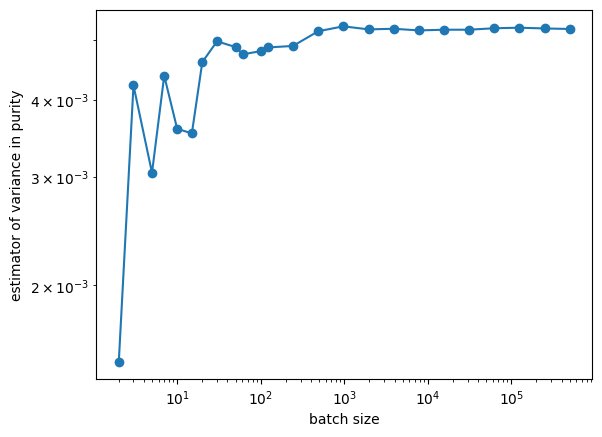

In [86]:
# sort batch_size_opts and std_list according to the former
batch_size_opts, std_list = zip(*sorted(zip(batch_size_opts, std_list)))
num_batches_opts = [int(len(samples) / batch_size) for batch_size in batch_size_opts]

plt.plot(num_batches_opts, std_list, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("batch size")
plt.ylabel("estimator of variance in purity")

# Fix system size and see convergence to Haar purity

In [70]:
context = RunContext(
    max_iter=5000, 
    progress_interval=5000
)

num_sites = 4
k_copies = 2
chi_list = [2,4,6,8,10,12,14,16]
purity_list = []
dataset = []
for chi in tqdm(chi_list): 
    samples = trace_samples(num_sites, chi, context, open_rmps_even, scaled=False)
    purity = samples_to_purity(samples, k_copies)
    purity_list.append(purity)
    dataset.append(samples) 

  0%|          | 0/8 [00:00<?, ?it/s]

Starting new sampling run.


Step 5000 at 2025-05-07T15:20:11
Max iterations reached.


 12%|█▎        | 1/8 [00:06<00:44,  6.36s/it]

Starting new sampling run.


Step 5000 at 2025-05-07T15:20:16
Max iterations reached.


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

Starting new sampling run.


Step 5000 at 2025-05-07T15:20:22
Max iterations reached.


 38%|███▊      | 3/8 [00:17<00:29,  5.84s/it]

Starting new sampling run.


Step 5000 at 2025-05-07T15:20:29
Max iterations reached.


 50%|█████     | 4/8 [00:24<00:25,  6.26s/it]

Starting new sampling run.


Step 5000 at 2025-05-07T15:20:37
Max iterations reached.


 62%|██████▎   | 5/8 [00:33<00:21,  7.07s/it]

Starting new sampling run.


Step 5000 at 2025-05-07T15:20:48
Max iterations reached.


 75%|███████▌  | 6/8 [00:43<00:16,  8.17s/it]

Starting new sampling run.


Step 5000 at 2025-05-07T15:21:01
Max iterations reached.


 88%|████████▊ | 7/8 [00:56<00:09,  9.92s/it]

Starting new sampling run.


Step 5000 at 2025-05-07T15:21:17
Max iterations reached.


100%|██████████| 8/8 [01:12<00:00,  9.11s/it]


In [71]:
purity_list

[0.016114492980321894,
 0.008428123077290562,
 0.00798755375518908,
 0.0077451003590455,
 0.007626925950871742,
 0.007799998286183896,
 0.007397112112643208,
 0.007296255110470443]

In [59]:
purity_list

[0.016054767154619395,
 0.00838618920075211,
 0.007960571889541341,
 0.007933643027310353,
 0.0077019167164885044,
 0.007470320469455058,
 0.0074757639405118904,
 0.0074025960909154835]

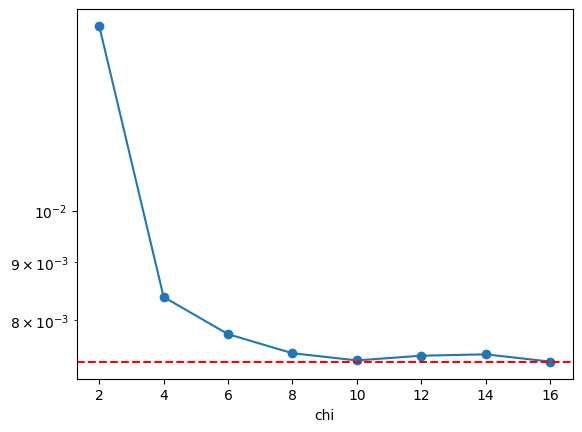

In [50]:
hp = haar_purity(n, k_copies, scaled=False)
plt.plot(chi_list, purity_list, marker="o")
plt.axhline(hp, color="r", linestyle="--")
plt.xlabel("chi")
plt.yscale('log')

In [55]:
purity_list

[0.014556041002776453,
 0.008390093870104216,
 0.00777977167052572,
 0.007483795539388879,
 0.0073754777144434845,
 0.0074463373542620215,
 0.00746711454785247,
 0.007357707886658086]

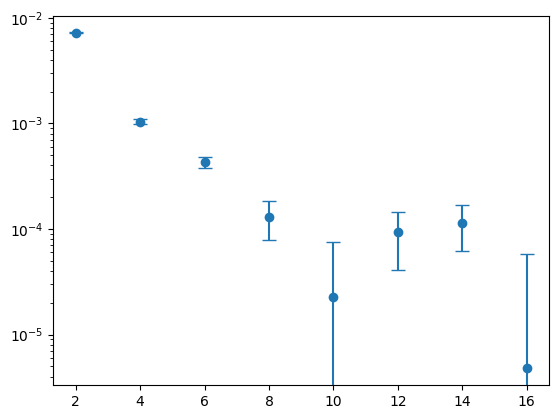

In [54]:
two_norm_error = [h-hp for h in purity_list]
#plt.plot(chi_list, two_norm_error, marker="o")
plt.errorbar(chi_list, two_norm_error, yerr=np.std(ps)/np.sqrt(10), fmt='o', capsize=5)
plt.yscale('log')

In [49]:
ps = [samples_to_purity(samples[i*5000:(i+1)*5000], 2) for i in range(10)]

In [51]:
np.std(ps)

0.0001669890526576689

In [10]:
def process(samples, k_copies, num_batches, n=None, unscale=False): 
    batch_size = int(round(len(samples) // num_batches))
    batches = [samples[i * batch_size: (i + 1) * batch_size] for i in range(num_batches)]
    sc = 2**(n*k_copies) if unscale else 1
    purities = [samples_to_purity(batch, k_copies)/sc for batch in batches]
    return np.mean(purities), np.std(purities, ddof=1)/np.sqrt(num_batches)

geometry = "open"
n = 4
k_copies = 2
chi_list = [2,4,6,8,10,12,14,16,18,20]
p_means = []
p_stds = []
real_chi_list = []
for chi in chi_list: 
    file = f"{geometry}_{n}_{chi}.pickle"
    if os.path.exists(file):
        with open(file, "rb") as f:
            data = pickle.load(f)
            samples = data["samples"]
            print(len(samples), chi)
            num_batches = 1000
            p_mean, p_std = process(samples, k_copies, num_batches, n=n, unscale=True)
            p_means.append(p_mean)
            p_stds.append(p_std)
            real_chi_list.append(chi)

1000000 2
1000000 4
1000000 6
1000000 8
1000000 10
1000000 12
1000000 14
1000000 16
1000000 18
1000000 20


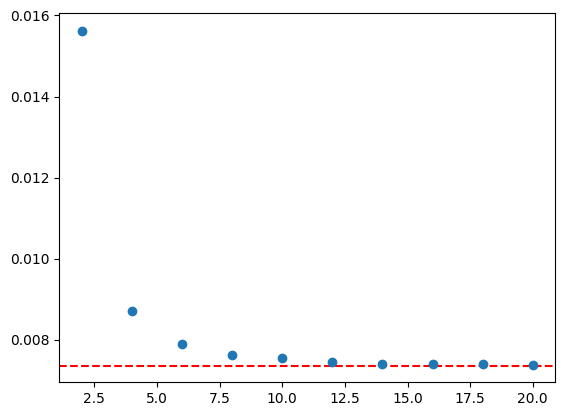

In [11]:
hp = haar_purity(n, k_copies, scaled=False)
plt.errorbar(real_chi_list, p_means, yerr=p_stds, fmt="o", label="numerical")
plt.axhline(hp, color="red", linestyle="--", label="theoretical")

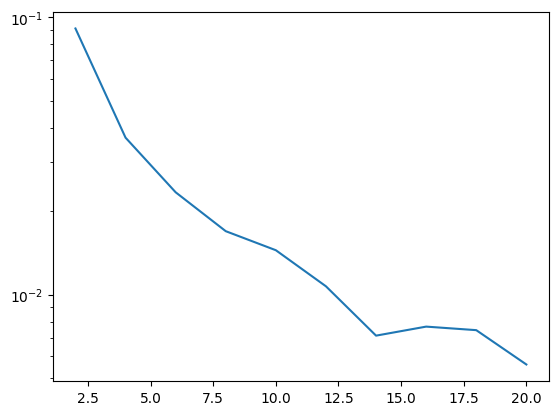

In [12]:
two_norm_errs = [np.sqrt(p_mean-hp) for p_mean in p_means]
plt.plot(real_chi_list, two_norm_errs)
plt.yscale('log')

# Processing data

In [69]:
n = 4
chi_list = [2,4,6,8,10,12,14,16]

purities = []
for chi in chi_list: 
    file = f"open_{n}_{chi}.pickle"
    with open(file, "rb") as f:
        data = pickle.load(f)
    samples = data["samples"]
    print(len(samples))
    purity = samples_to_purity(samples, k_copies)
    purities.append(purity)

1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000


In [67]:
hp = haar_purity(4, 2, scaled=True)
one_err = [p-hp for p in purities]
two_err = [e/2**(n*k_copies) for e in one_err]
two_err

[0.008269081008077484,
 0.0013518508509323159,
 0.0005464770261095573,
 0.0002866714089937196,
 0.00020904725969089245,
 0.00011490507706951938,
 5.070424249674441e-05,
 5.8890434870986254e-05]

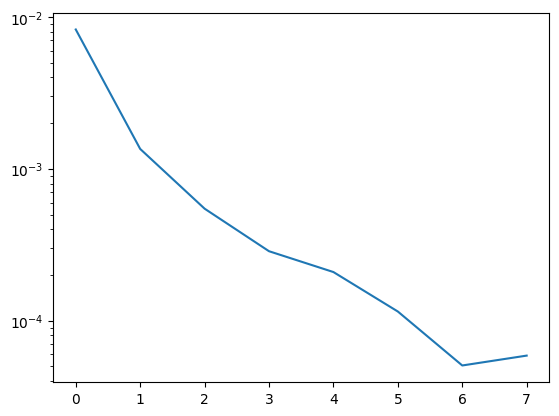

In [68]:
plt.plot(two_err)
plt.yscale('log')

In [100]:
geometry = "open"
k_copies = 2
chi_list = [2,4,6,8,10,12,14,16,18,20]

n_list = np.arange(4,40)
num_batches = 1000

plotter = {}
for chi in chi_list:
    p_means = []
    p_stds = []
    real_n_list = []
    for n in n_list: 
        filename = f"{geometry}_{n}_{chi}.pickle"
        if os.path.exists(filename): 
            with open(filename, "rb") as f:
                data = pickle.load(f)
                samples = data["samples"]
                #print(len(samples))

            batch_size = int(round(len(samples) / num_batches))
            batches = [samples[i * batch_size: (i + 1) * batch_size] for i in range(num_batches)]
            p_list = [samples_to_purity(batch, k_copies) for batch in tqdm(batches)]
            p_means.append(np.mean(p_list))
            p_stds.append(np.std(p_list, ddof=1)/np.sqrt(num_batches))
            real_n_list.append(n)

    hp_list = [haar_purity(n, k_copies, scaled=True) for n in real_n_list]
    err1_means = [(rp-hp) for rp, hp in zip(p_means, hp_list)]
    
    #err2_means = [(rp-hp)/(2**(n*k_copies)) for n, rp, hp in zip(real_n_list, p_means, hp_list)]
    #log_err2_means = [np.log(err2) for err2 in err2_means]
    log_err2_alt_means = [np.log(err1) - n*k_copies*np.log(2) for n, err1 in zip(real_n_list, err1_means)]
    #print(log_err2_means)
    print(log_err2_alt_means)
    #print("")
    #err1_means = [(rp-hp) for rp, hp in zip(p_means, hp_list)]
    plotter[chi] = (real_n_list, log_err2_alt_means)

100%|██████████| 1000/1000 [00:00<00:00, 18306.31it/s]


[-4.795231899691052, -6.6194623053422115, -8.61761793009451, -10.716859073564732, -12.854669177951127, -15.024351091605453, -17.218228535375125, -19.31463916166559, -21.526382350236307, -23.58996678583626, -25.865721243169958, -27.987244975140072, -30.273489705099507, -32.04649853650444, -34.39448557734086, -36.872869407938836, -38.65774314193915, -41.09608784024507]


100%|██████████| 1000/1000 [00:00<00:00, 18127.11it/s]


[-6.606280624804526, -8.586643778109643, -10.860639105282841, -13.238053725536258, -15.719143411833096, -18.202927901804735, -20.733149930800977, -23.275333657229286, -25.839618775193106, -28.42663443713336, -30.994596910889822, -33.56187468503425, -36.16323205466906, -38.755500307103034, -41.345603824837646, -43.9181041675577, -46.50723114914819, -49.17086704266638]


100%|██████████| 1000/1000 [00:00<00:00, 18140.59it/s]


[-7.512018289457184, -9.512111084445529, -11.839091074685424, -14.273382247600532]


100%|██████████| 1000/1000 [00:00<00:00, 18010.81it/s]


[-8.157173914520317, -10.119813057237941, -12.452050128779945, -17.419068716226647, -19.98657005722687, -22.612643515422953, -25.213051063256035, -27.850915964871636, -30.48928303960033, -33.14119796881459, -35.81917253734524, -38.49661283437403, -41.15779569451394, -43.85352673601981, -46.53511464447293, -49.2196860975254, -51.913555530132925]


100%|██████████| 1000/1000 [00:00<00:00, 18205.39it/s]


[-8.472950208638476, -10.549471862227652, -12.925678317813237]


100%|██████████| 1000/1000 [00:00<00:00, 18331.43it/s]


[-9.071404187231805, -10.992382311898808, -13.236644053313144, -15.724455786962109]


100%|██████████| 1000/1000 [00:00<00:00, 18201.36it/s]


[-9.88950097243119, -11.255700092644233, -13.677172311688373, -16.107008744087615]


100%|██████████| 1000/1000 [00:00<00:00, 37550.06it/s]


[-9.739831876572676, -11.60959287282045, -13.990170170098777, -16.388639977947562, -18.950571001847557, -21.482398640984524, -24.13059732102256, -26.73957301503136, -29.410400742523535, -32.09480218338813, -34.75994504563516, -37.45193785013594, -40.103570852057494, -42.78316458084148, -45.46095571302198, -48.219723081951265, -50.89323724882293, -53.61184600174719]


100%|██████████| 1000/1000 [00:00<00:00, 18283.24it/s]


[-9.798514193884994, -12.048041840281975, -13.99741109732845, -16.65325980400311]


100%|██████████| 1000/1000 [00:00<00:00, 17972.07it/s]

[-10.367781714911265, -11.921366806729564, -14.634297540859334, -16.797834196935653]


In [103]:
# for each chi, find the slope between x=plotter[chi][0] and y=plotter[chi][1] using linear regression
from scipy.stats import linregress
slope_list = []
real_chi_list = []
for chi in chi_list: 
    n_list = plotter[chi][0]
    y_list = plotter[chi][1]

    slope, intercept, r_value, p_value, std_err = linregress(n_list, y_list)
    print(f"chi={chi}: slope={slope}, intercept={intercept}, r_value={r_value}, p_value={p_value}, std_err={std_err}")
    if abs(r_value)>0.99: 
        real_chi_list.append(chi)
        slope_list.append(slope)
        print("yay")

chi=2: slope=-1.0735259399856871, intercept=-0.09326352356391254, r_value=-0.9998984419673903, p_value=5.687423819689872e-31, std_err=0.003825231914378749
yay
chi=4: slope=-1.2663955866319327, intercept=-0.7337724301535182, r_value=-0.9997990165041878, p_value=1.3376736763245879e-28, std_err=0.006348484520386478
yay
chi=6: slope=-1.130553593233497, intercept=-2.8702755214126885, r_value=-0.9990323751652787, p_value=0.000967624834721348, std_err=0.0351933016046767
yay
chi=8: slope=-1.3031942973466322, intercept=-2.0506900045165217, r_value=-0.9997404987677412, p_value=4.6785252126821e-26, std_err=0.007667129332235277
yay
chi=10: slope=-1.11318202729369, intercept=-3.9702746324643137, r_value=-0.9992458905924958, p_value=0.024725187632765756, std_err=0.043255775276164754
yay
chi=12: slope=-1.1101708270302624, intercept=-4.48502579563963, r_value=-0.9983682154800615, p_value=0.001631784519938506, std_err=0.044900712024361196
yay
chi=14: slope=-1.0536997767006708, intercept=-5.356447093308

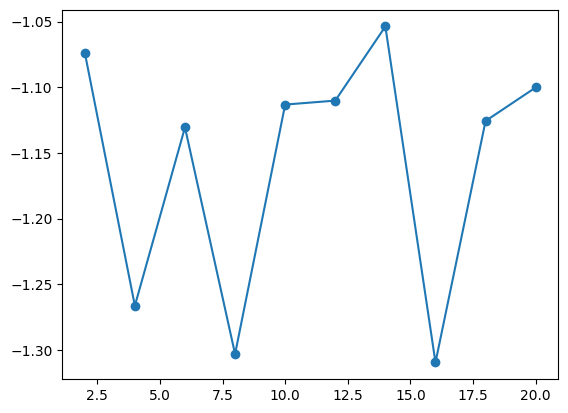

In [104]:
plt.plot(real_chi_list, slope_list, marker="o")

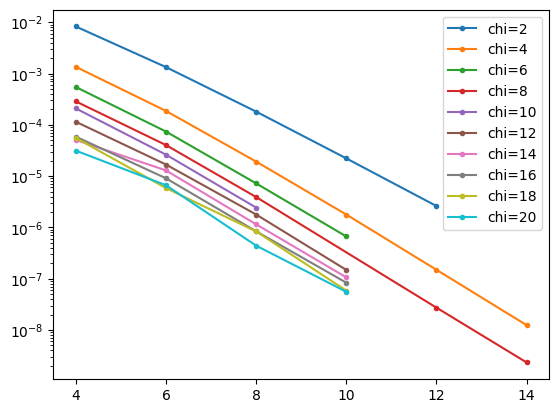

In [64]:
for chi in chi_list: 
    plt.plot(plotter[chi][0], plotter[chi][1], label=f"chi={chi}", marker="o", markersize=3)

plt.yscale('log')    
plt.legend()

In [89]:
# for each chi, find the slope between x=plotter[chi][0] and y=plotter[chi][1] using linear regression
from scipy.stats import linregress
slope_list = []
real_chi_list = []
for chi in chi_list: 
    slope, intercept, r_value, p_value, std_err = linregress(plotter[chi][0], np.log(plotter[chi][1]))
    print(f"chi={chi}: slope={slope}, intercept={intercept}, r_value={r_value}, p_value={p_value}, std_err={std_err}")
    if r_value>0.99: 
        real_chi_list.append(chi)
        slope_list.append(slope)
        print("yay")

chi=2: slope=-1.0278636817266997, intercept=-0.520592110834551, r_value=-0.9995483590685255, p_value=3.0592323372209644e-07, std_err=0.015451274857266406
chi=4: slope=-1.1679735700917833, intercept=-1.690519293735802, r_value=-0.9992384611477639, p_value=8.696913112345401e-07, std_err=0.022804061803608063
chi=6: slope=-1.130553593233497, intercept=-2.8702755214126885, r_value=-0.9990323751652787, p_value=0.000967624834721348, std_err=0.0351933016046767
chi=8: slope=-1.1950528014028676, intercept=-3.1104705224531077, r_value=-0.9991513750838384, p_value=2.967236993879187e-05, std_err=0.02844303304760059
chi=10: slope=-1.1131820272936905, intercept=-3.970274632464311, r_value=-0.9992458905924958, p_value=0.024725187632765756, std_err=0.04325577527616477
chi=12: slope=-1.1101708270302624, intercept=-4.48502579563963, r_value=-0.9983682154800615, p_value=0.001631784519938506, std_err=0.044900712024361196
chi=14: slope=-1.0536997767006706, intercept=-5.35644709330816, r_value=-0.99248322590

In [85]:
chi = 6
(plotter[chi][0], np.log(plotter[chi][1]))

([4, 6, 8, 10],
 array([ -7.51201829,  -9.51211108, -11.83909107, -14.22250698]))

In [82]:
k = -1
linregress(plotter[chi][0][:k], np.log(plotter[chi][1][:k]))

LinregressResult(slope=-1.0110038664683332, intercept=-0.6331177460444604, rvalue=-0.9995104315274527, pvalue=1.3002358180475827e-05, stderr=0.018271466932445912, intercept_stderr=0.15503853804189924)

In [84]:
k = -1
linregress(plotter[chi][0][:k], np.log(plotter[chi][1][:k]))

LinregressResult(slope=-1.1681687091078836, intercept=-1.6892183669617982, rvalue=-0.9992341089901682, pvalue=8.796589267761118e-07, stderr=0.0228730266061421, intercept_stderr=0.22018382185712396)

In [87]:
k = 100
linregress(plotter[chi][0][:k], np.log(plotter[chi][1][:k]))

LinregressResult(slope=-1.1229223031580013, intercept=-2.9109757351486643, rvalue=-0.9992001516982181, pvalue=0.000799848301781925, stderr=0.03177709337946462, intercept_stderr=0.23351299286538546)

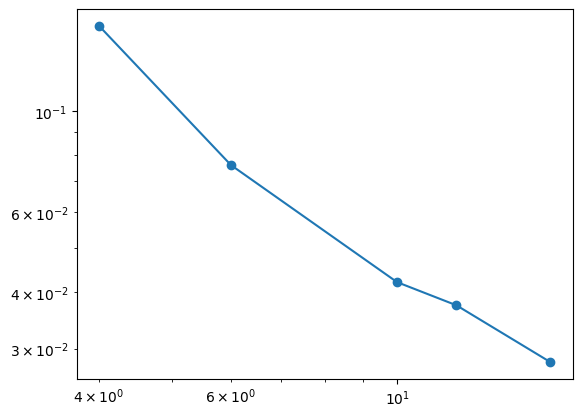

In [57]:
plt.plot(real_chi_list, slope_list, marker="o")
plt.yscale('log')
plt.xscale('log')

In [58]:
linregress(np.log(real_chi_list), np.log(slope_list))

LinregressResult(slope=np.float64(-1.2085150567762586), intercept=np.float64(-0.2997518601589291), rvalue=np.float64(-0.9899053068125292), pvalue=np.float64(0.0012156675928679274), stderr=np.float64(0.09989886471229587), intercept_stderr=np.float64(0.22021354358368764))

In [115]:
data

{'step': 610000,
 'samples': [np.float64(1.2933588885814495),
  np.float64(0.4377777256415724),
  np.float64(0.9683306828222815),
  np.float64(0.3263587174080869),
  np.float64(0.40659555659484437),
  np.float64(1.0716663552485202),
  np.float64(0.7274689969978437),
  np.float64(1.3059657122067792),
  np.float64(1.1871234216910047),
  np.float64(0.5560596798353745),
  np.float64(0.7593759449535045),
  np.float64(0.15075952997767753),
  np.float64(0.8605360268965939),
  np.float64(0.6555205859376777),
  np.float64(1.016951786262407),
  np.float64(1.7588990944400356),
  np.float64(1.490195207012636),
  np.float64(0.9678411439269893),
  np.float64(1.1507007509011897),
  np.float64(1.4233164805906702),
  np.float64(0.6264971390803419),
  np.float64(1.641629766775974),
  np.float64(0.7464553357207067),
  np.float64(0.009510363734366856),
  np.float64(0.6731912826081002),
  np.float64(1.5814881386151607),
  np.float64(1.1388798608612207),
  np.float64(1.128289447956959),
  np.float64(1.65478

<ErrorbarContainer object of 3 artists>

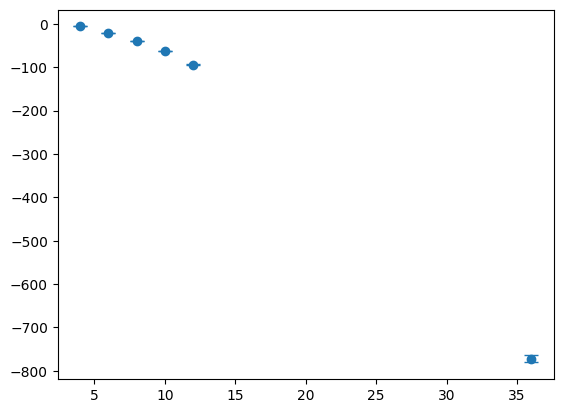

In [111]:

plt.errorbar(real_n_list, log_err2_means, yerr=log_err2_stds, fmt="o", capsize=5)

In [97]:
log_err2_means

[np.float64(-5.9995643583080875),
 np.float64(-20.379646336525575),
 np.float64(-39.56379134183381),
 np.float64(-62.92169075268348),
 np.float64(-94.08425867875016)]

In [98]:
log_err2_stds

[np.float64(0.031182434466563796),
 np.float64(0.05394583634202545),
 np.float64(0.0882299580785874),
 np.float64(0.14560234954978035),
 np.float64(1.795608926026095)]

# Processing PBC data

In [1]:
import os, sys, pickle
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

CURRENT_DIR = os.getcwd()
ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, ".."))
sys.path.append(ROOT_DIR)
from rmps_purity import samples_to_purity, samples_to_purity_with_error, haar_purity


def get_two_errs(chi):
    n_range = np.arange(4, 32, 2)
    included_n = []
    purities = []
    for n in n_range:
        file = os.path.join("data", f"periodic_{n}_{chi}.pickle")
        if os.path.exists(file):
            included_n.append(n)
            with open(file, "rb") as f:
                data = pickle.load(f)

            samples = data["samples"]
            purity = samples_to_purity(samples, k_copies)
            purities.append(purity)

    one_err_sq = [p - haar_purity(n, k_copies, scaled=True) for p, n in zip(purities, included_n)]
    one_err = np.sqrt(np.array(one_err_sq))
    two_err = [e / 2**(n * k_copies / 2) for e, n in zip(one_err, included_n)]
    return included_n, two_err

def get_one_errs(chi):
    n_range = np.arange(10, 50, 2)
    included_n = []
    one_err = []
    one_err_uncert = []
    for n in n_range:
        file = os.path.join("data", f"periodic_{n}_{chi}.pickle")
        if os.path.exists(file):
            with open(file, "rb") as f:
                data = pickle.load(f)

            samples = data["samples"]
            purity, purity_err = samples_to_purity_with_error(samples, k_copies)
            err = purity - haar_purity(n, k_copies, scaled=True)

            if err > 0 and len(samples) > 1e5:    ############  <====== might wanna change this later
                sqrt_err = np.sqrt(err)
                sqrt_err_uncert = 0.5 * purity_err / sqrt_err  # propagate purity_err
                one_err.append(sqrt_err)
                one_err_uncert.append(sqrt_err_uncert)
                included_n.append(n)
            
            else: 
                print(f"Negative error for n={n}, chi={chi}: {err} or too few samples {len(samples)}")

    return included_n, one_err, one_err_uncert

def linear_regression_with_slope_error(x, y, y_err):
    x = np.array(x, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    y_err = np.array(y_err, dtype=np.float64)

    # Weights = 1/σ²
    w = 1 / y_err**2
    W = np.sum(w)
    x_bar = np.sum(w * x) / W
    y_bar = np.sum(w * y) / W

    # Slope
    S_xx = np.sum(w * (x - x_bar)**2)
    S_xy = np.sum(w * (x - x_bar) * (y - y_bar))
    slope = S_xy / S_xx

    # Intercept
    intercept = y_bar - slope * x_bar

    # Variance of slope
    slope_var = 1 / S_xx
    slope_std = np.sqrt(slope_var)

    return slope, slope_std, intercept

import scienceplots
def set_style(grid=True, axes_label_size=8, xtick_label_size=8, ytick_label_size=8, linewidth=1.5):
    plt.style.use(['science', 'grid', 'no-latex'])
    plt.rcParams['image.cmap'] = 'cividis'
    
    plt.rcParams['axes.labelsize'] = axes_label_size   
    plt.rcParams['xtick.labelsize'] = xtick_label_size  
    plt.rcParams['ytick.labelsize'] = ytick_label_size
    plt.rcParams['legend.fontsize'] = 8 
    plt.rcParams['lines.linewidth'] = linewidth
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.dpi'] = 300 
    
    plt.rcParams['axes.titlesize'] = 10
    
    plt.rcParams['axes.grid'] = grid  
    plt.rcParams['axes.spines.top'] = True 
    plt.rcParams['axes.spines.right'] = True

In [8]:
# test if data has been generated

chi_list = [16]
n_list = np.arange(4,50,2)
purities = []

incompletes = []
undones = []
for chi in chi_list: 
    for n in n_list:
        file = f"data/periodic_{n}_{chi}.pickle"
        if os.path.exists(file):
            with open(file, "rb") as f:
                data = pickle.load(f)
            samples = data["samples"]
            if len(samples) < 1e6: 
                pass
                incompletes.append(n)
                print(f"data for chi={chi} and n={n} exists but has {len(samples)} samples. Please generate more samples.")
        else: 
            undones.append(n)
            #print(f"bond dimension {chi} and n={n} not found in data directory. Please generate the data first.")
            #pass
    print("")
print("incompletes: ", incompletes)
print("undones: ", undones)

data for chi=16 and n=10 exists but has 850000 samples. Please generate more samples.
data for chi=16 and n=14 exists but has 950000 samples. Please generate more samples.
data for chi=16 and n=16 exists but has 10000 samples. Please generate more samples.
data for chi=16 and n=20 exists but has 530000 samples. Please generate more samples.
data for chi=16 and n=22 exists but has 10000 samples. Please generate more samples.
data for chi=16 and n=24 exists but has 410000 samples. Please generate more samples.
data for chi=16 and n=26 exists but has 700000 samples. Please generate more samples.
data for chi=16 and n=28 exists but has 370000 samples. Please generate more samples.
data for chi=16 and n=30 exists but has 790000 samples. Please generate more samples.
data for chi=16 and n=32 exists but has 10000 samples. Please generate more samples.
data for chi=16 and n=34 exists but has 310000 samples. Please generate more samples.
data for chi=16 and n=36 exists but has 10000 samples. Pl

Text(0.5, 0.98, 'n=30')

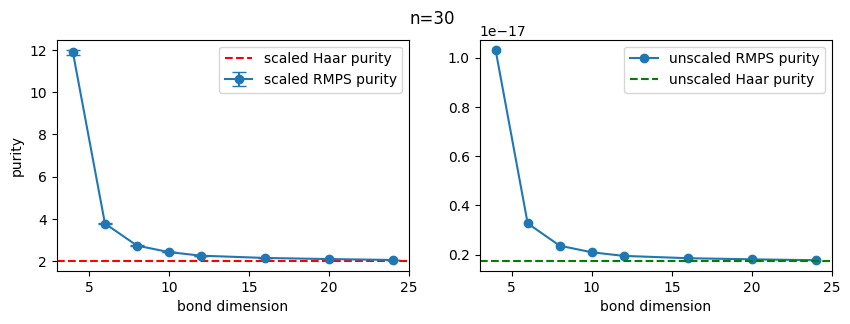

In [3]:
# test convergence
n = 30
chi_list = [4,6,8,10,12,16,20,24]
purities = []
err_bars = []
k_copies = 2 

for chi in chi_list:
    file = f"data/periodic_{n}_{chi}.pickle"
    if os.path.exists(file):
        with open(file, "rb") as f:
            data = pickle.load(f)
        samples = data["samples"]
        purity, err = samples_to_purity_with_error(samples, k_copies)
        purities.append(purity)
        err_bars.append(err)
    else:
        print(f"file {file} not found.")

hp = haar_purity(n, k_copies, scaled=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].errorbar(chi_list, purities, yerr=err_bars, fmt="-o", capsize=5, label="scaled RMPS purity")
axs[0].axhline(hp, color="red", linestyle="--", label="scaled Haar purity")
axs[1].plot(chi_list, np.array(purities)/2**(n*k_copies), marker="o", label="unscaled RMPS purity")
axs[1].axhline(hp/2**(n*k_copies), color="green", linestyle="--", label="unscaled Haar purity")

axs[0].set_ylabel("purity")
axs[0].set_xlabel("bond dimension")
axs[1].set_xlabel("bond dimension")
axs[0].legend()
axs[1].legend()
plt.suptitle(f"n={n}")


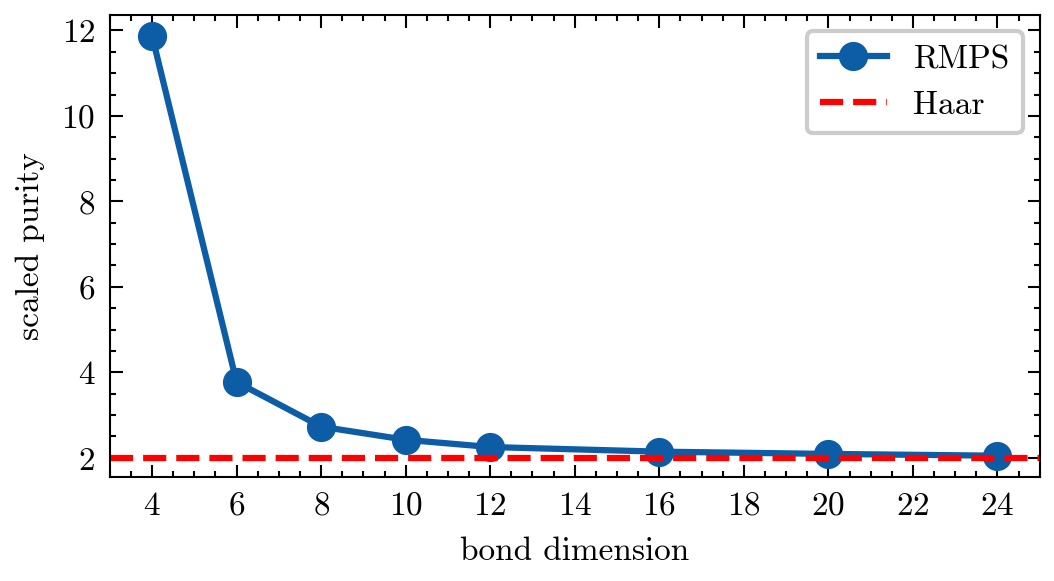

In [4]:
set_style(grid=False)
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(chi_list, purities, marker="o", label="RMPS")
ax.axhline(hp, color="red", linestyle="--", label="Haar")
ax.set_xlabel("bond dimension")
ax.set_ylabel("scaled purity")
ax.set_xticks(np.arange(4, 26, 2))
plt.legend()
plt.savefig("figures/np0.svg", bbox_inches='tight')

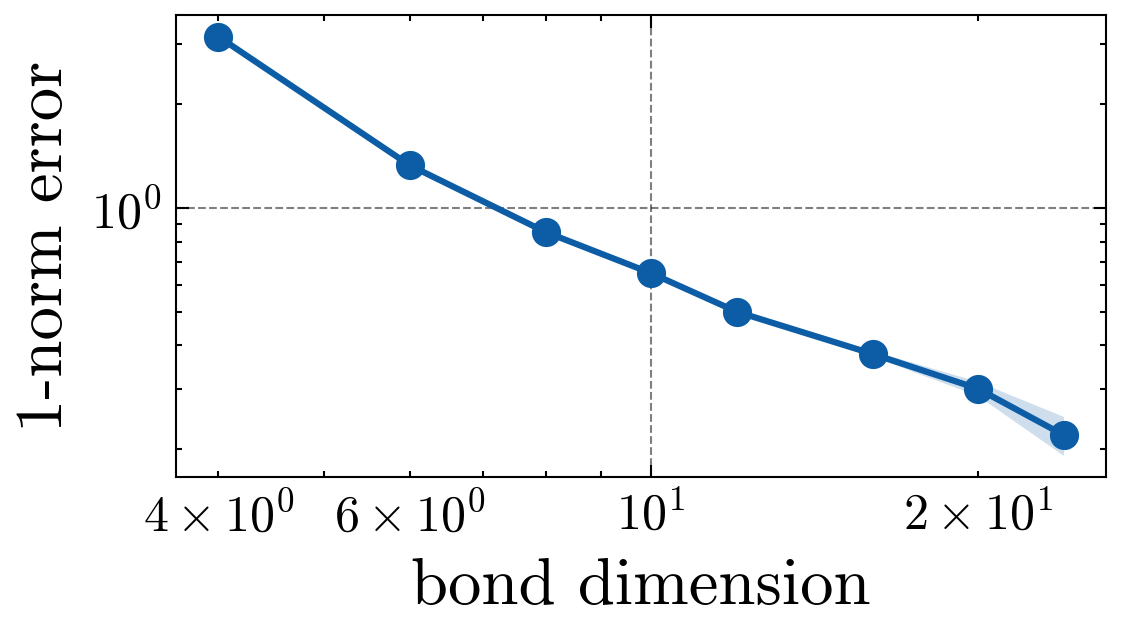

In [5]:
set_style(grid=True, axes_label_size=16, xtick_label_size=12, ytick_label_size=12)
fig, ax = plt.subplots(figsize=(4, 2))

one_err_sq = np.array(purities) - hp
one_err = np.sqrt(one_err_sq)
err_one_err = err_bars / (2 * one_err)

ax.plot(chi_list, one_err, marker="o")
ax.fill_between(chi_list, one_err - err_one_err, one_err + err_one_err, alpha=0.2)

ax.set_xlabel("bond dimension")
ax.set_ylabel("1-norm error")
ax.set_yscale('log')
ax.set_xscale('log')
plt.savefig("figures/np1.svg", bbox_inches='tight')

In [4]:
n_arr = []
one_err_arr = []

slope_list = []
intercept_list = []
slope_err_list = []
chi_list = [8,10,12,16,20,24]
k_copies = 2

for chi in chi_list:
    included_n, one_err, one_err_uncert = get_one_errs(chi)
    slope, slope_err, intercept = linear_regression_with_slope_error(included_n, one_err, one_err_uncert)
    slope_list.append(slope)
    slope_err_list.append(slope_err)
    n_arr.append(included_n)
    one_err_arr.append(one_err)
    intercept_list.append(intercept)

    print(f"Bond dimension: {chi}, Slope: {slope:.5f} ± {slope_err:.5f}")

drop = 0
result = linregress(np.log(chi_list[drop:]), np.log(slope_list[drop:]))
print(f"Slope: {result.slope}, Intercept: {result.intercept}, R-squared: {result.rvalue**2}, P-value: {result.pvalue}")
fitted_line = np.exp(result.intercept) * np.array(chi_list[drop:])**result.slope

Bond dimension: 8, Slope: 0.02026 ± 0.00009
Negative error for n=28, chi=10: -1.762041916757776 or too few samples 1000000
Bond dimension: 10, Slope: 0.01357 ± 0.00010
Negative error for n=28, chi=12: -0.6345939418774553 or too few samples 1000000
Bond dimension: 12, Slope: 0.01037 ± 0.00012
Negative error for n=16, chi=16: 0.11495462682283808 or too few samples 10000
Negative error for n=22, chi=16: 0.0957355432879834 or too few samples 10000
Negative error for n=28, chi=16: -0.9674711912809537 or too few samples 370000
Negative error for n=32, chi=16: 0.20347459332879136 or too few samples 10000
Negative error for n=36, chi=16: 0.04231014107945219 or too few samples 10000
Negative error for n=40, chi=16: 0.2318258516916485 or too few samples 10000
Negative error for n=42, chi=16: 0.26926319837687407 or too few samples 10000
Negative error for n=48, chi=16: 0.22389753511444743 or too few samples 84000
Bond dimension: 16, Slope: 0.00710 ± 0.00024
Negative error for n=12, chi=20: 0.0195

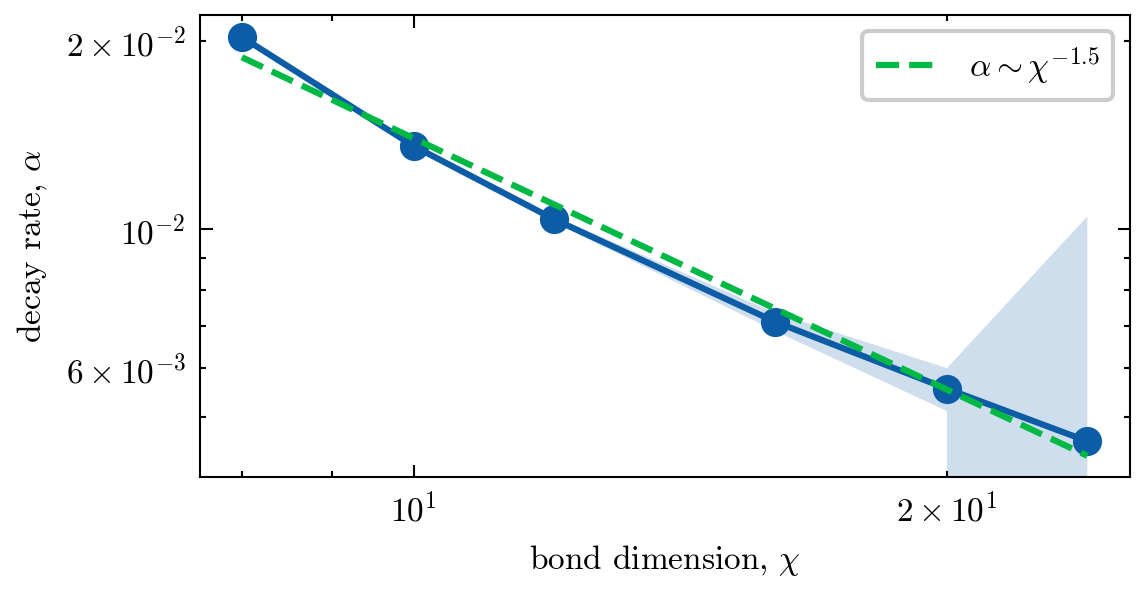

In [5]:
set_style(grid=False)
fig, ax = plt.subplots(figsize=(4, 2))

ax.plot(chi_list, slope_list, marker="o")
ax.fill_between(chi_list, np.array(slope_list) - np.array(slope_err_list), np.array(slope_list) + np.array(slope_err_list), alpha=0.2)
ax.plot(chi_list[drop:], fitted_line, linestyle="--", label=r"$\alpha\sim \chi^{-1.5}$")

ax.set_xlabel(r"bond dimension, $\chi$")
ax.set_ylabel(r"decay rate, $\alpha$")
ax.set_yscale('log')
ax.set_xscale('log')

plt.legend()
#plt.savefig("figures/np2.svg", bbox_inches='tight')

Text(0, 0.5, '1-norm error')

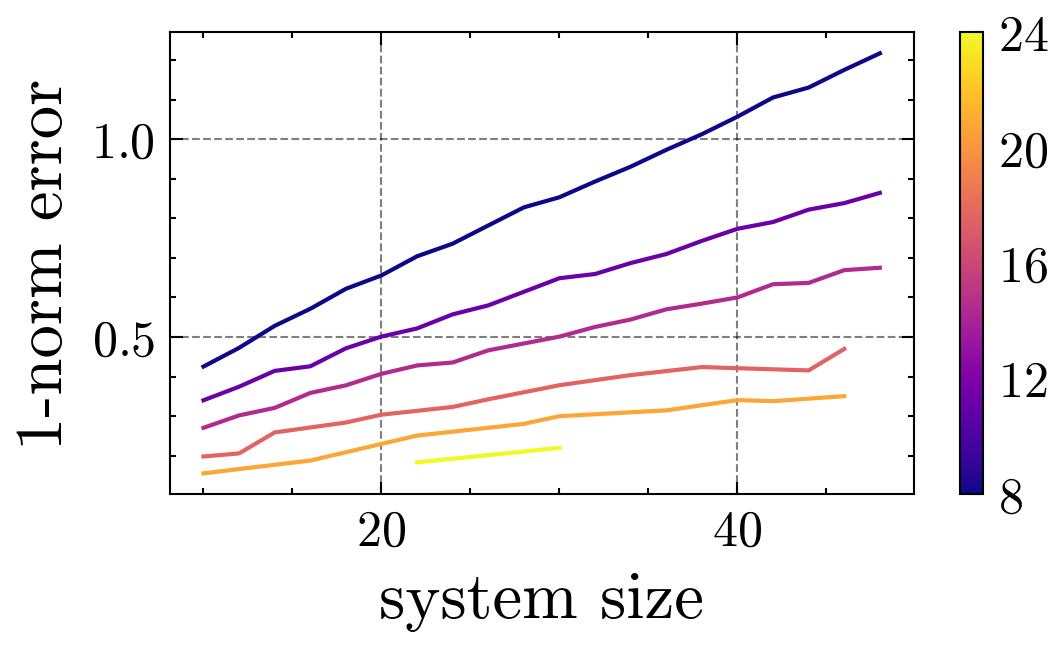

In [6]:
set_style(grid=True, axes_label_size=16, xtick_label_size=12, ytick_label_size=12, linewidth=1)

fig, ax = plt.subplots(figsize=(4, 2))
colors = plt.cm.plasma(np.linspace(0, 1, len(chi_list)))


for i in range(len(chi_list)):
    ax.plot(n_arr[i], one_err_arr[i], color=colors[i])

import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=chi_list[0], vmax=chi_list[-1])
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_ticks(np.arange(8, 26, 4))

ax.set_xlabel("system size")
ax.set_ylabel("1-norm error")
#plt.yscale("log")
#plt.savefig("figures/np3.svg", bbox_inches='tight')

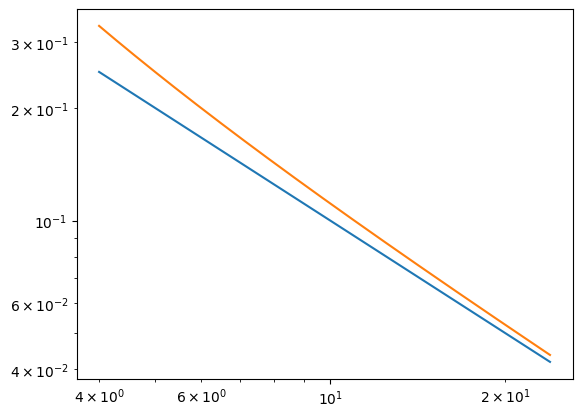

In [12]:
x = np.arange(4,24,0.1)
plt.plot(x,1/x, label="exact power law")
plt.plot(x, 1/x + 1/x**2 + 1/x**3 + 1/x**4, label="mixture of power laws")
plt.yscale('log')
plt.xscale('log')

# Testing TI pipeline

In [1]:
import os, sys, pickle
import numpy as np
from scipy.stats import linregress
from qaravan.tensorQ import haar_purity, ti_rmps
from qaravan.core import RunContext
import matplotlib.pyplot as plt

CURRENT_DIR = os.getcwd()
ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, ".."))
sys.path.append(ROOT_DIR)
from rmps_purity import samples_to_purity_with_error, trace_samples

In [4]:
num_sites = 4
chi_list = [4,8,12,16]
k_copies = 2
num_samples = 20000

context = RunContext(
    max_iter=num_samples, 
    progress_interval=num_samples
)

func = ti_rmps
purities = []
err_bars = []
for chi in chi_list: 
    samples = trace_samples(num_sites, chi, context, func, scaled=True)
    purity, err = samples_to_purity_with_error(samples, k_copies)
    purities.append(purity)
    err_bars.append(err)

Starting new sampling run.


100%|█████████▉| 19952/20000 [00:23<00:00, 863.86it/s]

Step 20000 at 2025-06-14T13:09:17
Max iterations reached.


100%|█████████▉| 19999/20000 [00:23<00:00, 855.71it/s]

Starting new sampling run.



100%|█████████▉| 19985/20000 [00:51<00:00, 390.93it/s]

Step 20000 at 2025-06-14T13:10:09
Max iterations reached.


100%|█████████▉| 19999/20000 [00:51<00:00, 385.10it/s]

Starting new sampling run.



100%|█████████▉| 19993/20000 [02:25<00:00, 133.69it/s]

Step 20000 at 2025-06-14T13:12:34
Max iterations reached.


100%|█████████▉| 19999/20000 [02:25<00:00, 137.77it/s]

Starting new sampling run.



100%|█████████▉| 19996/20000 [07:22<00:00, 44.97it/s]

Step 20000 at 2025-06-14T13:19:56
Max iterations reached.


100%|█████████▉| 19999/20000 [07:22<00:00, 45.17it/s]


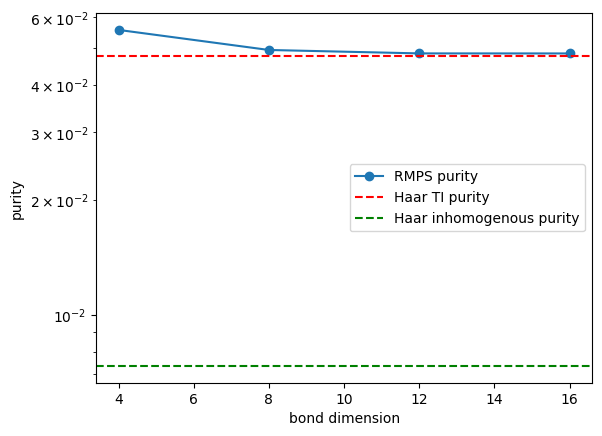

In [24]:
dim = one_copy_projector_ti_subspace(2, num_sites)
unscaled_purities = [p/(dim**k_copies) for p in purities]
plt.plot(chi_list, unscaled_purities, "o-", label="RMPS purity")

hp = haar_purity(num_sites, k_copies, scaled=False, ti=True)
plt.axhline(hp, color="red", linestyle="--", label="Haar TI purity")

hp = haar_purity(num_sites, k_copies, scaled=False, ti=False)
plt.axhline(hp, color="green", linestyle="--", label="Haar inhomogenous purity")

plt.yscale('log')
plt.xlabel("bond dimension")
plt.ylabel("purity")
plt.legend()


# Process TI data

In [19]:
import os, sys, pickle
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

CURRENT_DIR = os.getcwd()
ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, ".."))
sys.path.append(ROOT_DIR)
from rmps_purity import samples_to_purity, samples_to_purity_with_error, haar_purity

def get_one_errs(chi):
    n_range = np.arange(10, 50, 2)
    included_n = []
    one_err = []
    one_err_uncert = []
    for n in n_range:
        file = os.path.join("data", f"ti_{n}_{chi}.pickle")
        if os.path.exists(file):
            with open(file, "rb") as f:
                data = pickle.load(f)

            samples = data["samples"]
            purity, purity_err = samples_to_purity_with_error(samples, k_copies)
            err = purity - haar_purity(n, k_copies, scaled=True, ti=True)

            if err > 0:
                sqrt_err = np.sqrt(err)
                sqrt_err_uncert = 0.5 * purity_err / sqrt_err  # propagate purity_err
                one_err.append(sqrt_err)
                one_err_uncert.append(sqrt_err_uncert)
                included_n.append(n)
            
            else: 
                print(f"Negative error for n={n}, chi={chi}: {err}")

    return included_n, one_err, one_err_uncert

def linear_regression_with_slope_error(x, y, y_err):
    x = np.array(x, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    y_err = np.array(y_err, dtype=np.float64)

    # Weights = 1/σ²
    w = 1 / y_err**2
    W = np.sum(w)
    x_bar = np.sum(w * x) / W
    y_bar = np.sum(w * y) / W

    # Slope
    S_xx = np.sum(w * (x - x_bar)**2)
    S_xy = np.sum(w * (x - x_bar) * (y - y_bar))
    slope = S_xy / S_xx

    # Intercept
    intercept = y_bar - slope * x_bar

    # Variance of slope
    slope_var = 1 / S_xx
    slope_std = np.sqrt(slope_var)

    return slope, slope_std, intercept

import scienceplots
def set_style(grid=True, axes_label_size=8, xtick_label_size=8, ytick_label_size=8, linewidth=1.5):
    plt.style.use(['science', 'grid', 'no-latex'])
    plt.rcParams['image.cmap'] = 'cividis'
    
    plt.rcParams['axes.labelsize'] = axes_label_size   
    plt.rcParams['xtick.labelsize'] = xtick_label_size  
    plt.rcParams['ytick.labelsize'] = ytick_label_size
    plt.rcParams['legend.fontsize'] = 8 
    plt.rcParams['lines.linewidth'] = linewidth
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.dpi'] = 300 
    
    plt.rcParams['axes.titlesize'] = 10
    
    plt.rcParams['axes.grid'] = grid  
    plt.rcParams['axes.spines.top'] = True 
    plt.rcParams['axes.spines.right'] = True

In [100]:
# test if data has been generated

chi_list = [24]
n_list = np.arange(4,50,2)
purities = []

incompletes = []
undones = []
for chi in chi_list: 
    for n in n_list:
        file = f"data/ti_{n}_{chi}.pickle"
        if os.path.exists(file):
            with open(file, "rb") as f:
                data = pickle.load(f)
            samples = data["samples"]
            if len(samples) < 1e5: 
                #pass
                incompletes.append(n)
                #print(f"data for chi={chi} and n={n} exists but has {len(samples)} samples. Please generate more samples.")
        else: 
            undones.append(n)
            #print(f"bond dimension {chi} and n={n} not found in data directory. Please generate the data first.")
            pass
    print("")
print("incompletes", incompletes)
print("undones", undones)


incompletes [4, 6]
undones [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]


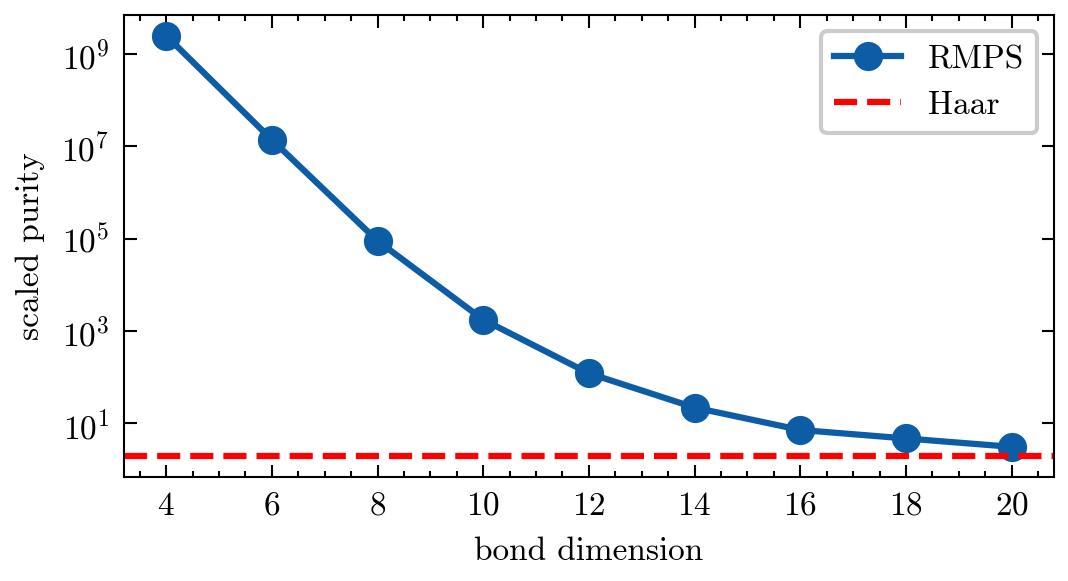

In [24]:
# test convergence
n = 30
chi_list = [4,6,8,10,12,14,16,18,20]
purities = []
err_bars = []
k_copies = 2 

for chi in chi_list:
    file = f"data/ti_{n}_{chi}.pickle"
    if os.path.exists(file):
        with open(file, "rb") as f:
            data = pickle.load(f)
        samples = data["samples"]
        purity, err = samples_to_purity_with_error(samples, k_copies)
        purities.append(purity)
        err_bars.append(err)
    else:
        print(f"file {file} not found.")

hp = haar_purity(n, k_copies, scaled=True, ti=True)

set_style(grid=False)
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(chi_list, purities, marker="o", label="RMPS")
ax.axhline(hp, color="red", linestyle="--", label="Haar")
ax.set_xlabel("bond dimension")
ax.set_ylabel("scaled purity")
ax.set_xticks(np.arange(4, 22, 2))
plt.legend()
plt.yscale('log')
plt.savefig("figures/nt0.svg", bbox_inches='tight')

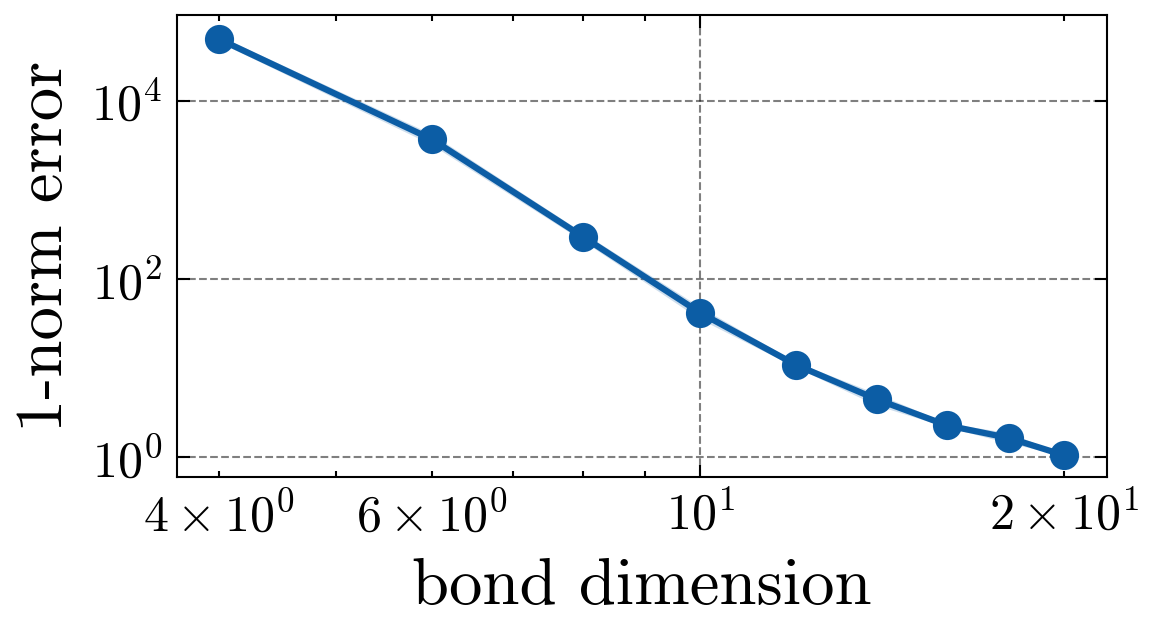

In [98]:
set_style(grid=True, axes_label_size=16, xtick_label_size=12, ytick_label_size=12)
fig, ax = plt.subplots(figsize=(4, 2))

one_err_sq = np.array(purities) - hp
one_err = np.sqrt(one_err_sq)
err_one_err = err_bars / (2 * one_err)

ax.plot(chi_list, one_err, marker="o")
ax.fill_between(chi_list, one_err - err_one_err, one_err + err_one_err, alpha=0.2)

# have y axis ticks at [0.01, 0.1, 1, 10, 100]


ax.set_xlabel("bond dimension")
ax.set_ylabel("1-norm error")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_yticks([1,100,10000])
plt.savefig("nt1.svg", bbox_inches='tight')

In [29]:
n_arr = []
one_err_arr = []

slope_list = []
intercept_list = []
slope_err_list = []
chi_list = [8,10,12,14,16,18,20]
k_copies = 2

for chi in chi_list:
    included_n, one_err, one_err_uncert = get_one_errs(chi)
    slope, slope_err, intercept = linear_regression_with_slope_error(included_n, one_err, one_err_uncert)
    slope_list.append(slope)
    slope_err_list.append(slope_err)
    n_arr.append(included_n)
    one_err_arr.append(one_err)
    intercept_list.append(intercept)

    print(f"Bond dimension: {chi}, Slope: {slope:.5f} ± {slope_err:.5f}")

drop = 0
result = linregress(np.log(chi_list[drop:]), np.log(slope_list[drop:]))
print(f"Slope: {result.slope}, Intercept: {result.intercept}, R-squared: {result.rvalue**2}, P-value: {result.pvalue}")
fitted_line = np.exp(result.intercept) * np.array(chi_list[drop:])**result.slope

Bond dimension: 8, Slope: 0.29727 ± 0.00517
Bond dimension: 10, Slope: 0.17171 ± 0.00423
Bond dimension: 12, Slope: 0.12840 ± 0.00264
Bond dimension: 14, Slope: 0.08947 ± 0.00330
Bond dimension: 16, Slope: 0.07634 ± 0.00181
Bond dimension: 18, Slope: 0.06103 ± 0.00435
Bond dimension: 20, Slope: 0.05426 ± 0.00115
Slope: -1.847224546479637, Intercept: 2.5471057736422535, R-squared: 0.989888599601381, P-value: 3.503336937992582e-06


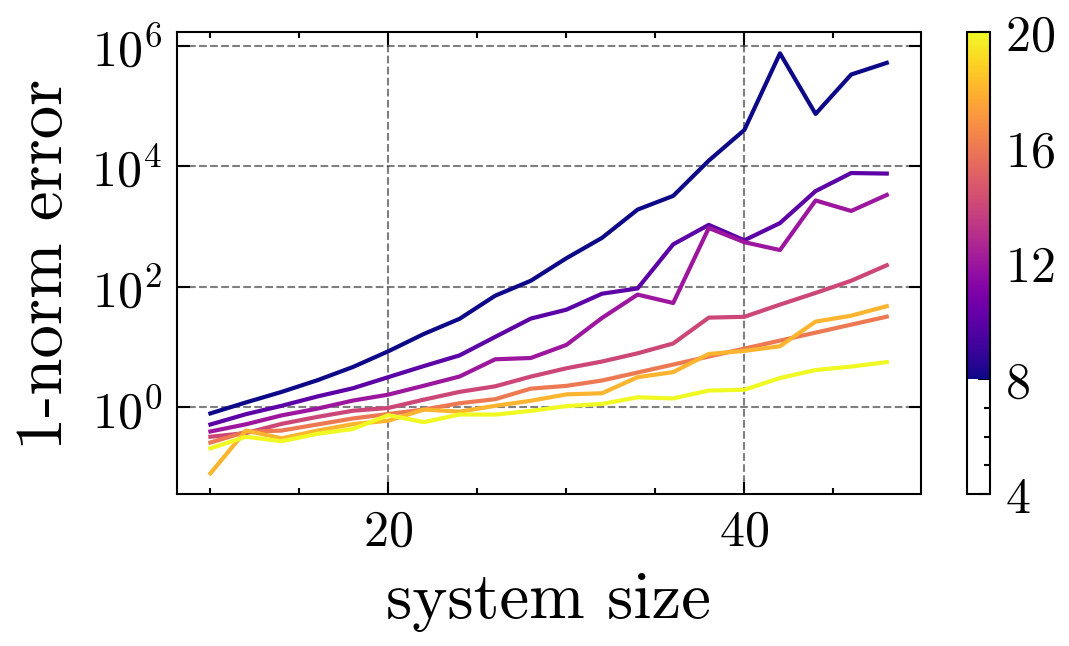

In [30]:
set_style(grid=True, axes_label_size=16, xtick_label_size=12, ytick_label_size=12, linewidth=1)

fig, ax = plt.subplots(figsize=(4, 2))
colors = plt.cm.plasma(np.linspace(0, 1, len(chi_list)))


for i in range(len(chi_list)):
    ax.plot(n_arr[i], one_err_arr[i], color=colors[i])

import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=chi_list[0], vmax=chi_list[-1])
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_ticks(np.arange(4, 22, 4))

ax.set_xlabel("system size")
ax.set_ylabel("1-norm error")
plt.yscale("log")
plt.savefig("figures/nt3.svg", bbox_inches='tight')

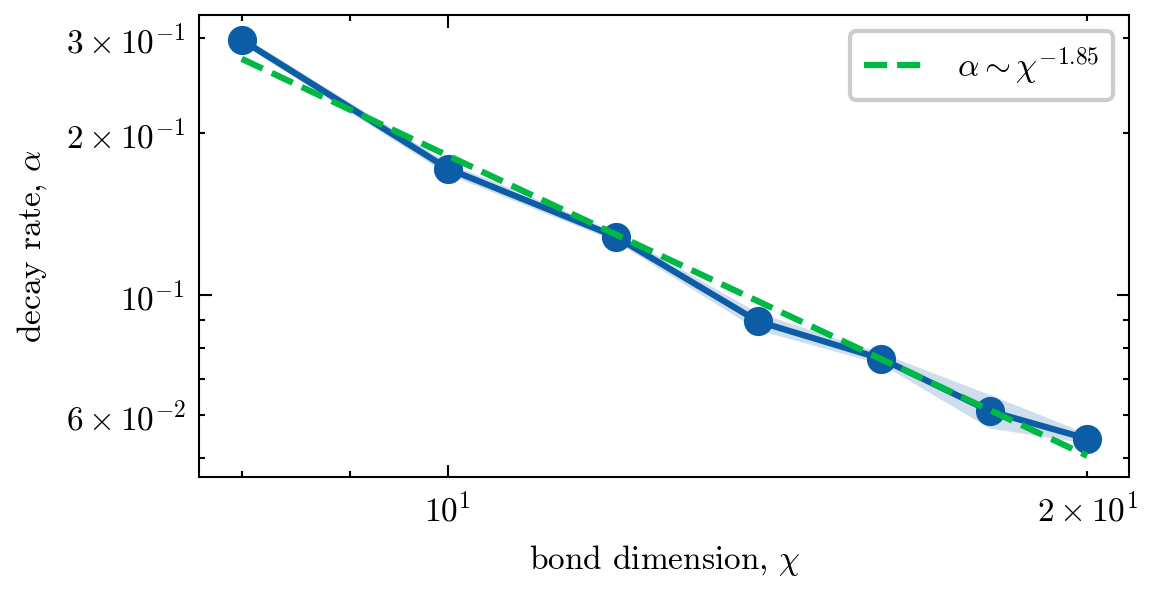

In [33]:
set_style(grid=False)
fig, ax = plt.subplots(figsize=(4, 2))

ax.plot(chi_list, slope_list, marker="o")
ax.fill_between(chi_list, np.array(slope_list) - np.array(slope_err_list), np.array(slope_list) + np.array(slope_err_list), alpha=0.2)
ax.plot(chi_list[drop:], fitted_line, linestyle="--", label=r"$\alpha\sim \chi^{-1.85}$")

ax.set_xlabel(r"bond dimension, $\chi$")
ax.set_ylabel(r"decay rate, $\alpha$")
ax.set_yscale('log')
ax.set_xscale('log')

plt.legend()
plt.savefig("figures/nt2.svg", bbox_inches='tight')

# Testing Gaussian pipeline

In [1]:
from qaravan.core import RunContext
from qaravan.tensorQ import periodic_rmps
import matplotlib.pyplot as plt

import os, sys
CURRENT_DIR = os.getcwd()
ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, ".."))
sys.path.append(ROOT_DIR)
from rmps_purity import samples_to_purity_with_error, trace_samples, haar_purity

In [14]:
num_sites = 20
chi_list = [2,3,4,5,6]
k_copies = 2
num_samples = 20000

context = RunContext(
    max_iter=num_samples, 
    progress_interval=num_samples
)

func = periodic_rmps
distrib = 'uniform'
purities_u = []
err_bars_u = []
for chi in chi_list: 
    samples = trace_samples(num_sites, chi, context, func, distrib=distrib, scaled=True)
    purity, err = samples_to_purity_with_error(samples, k_copies)
    purities_u.append(purity)
    err_bars_u.append(err)

Starting new sampling run.


100%|█████████▉| 19998/20000 [01:37<00:00, 199.87it/s]

Step 20000 at 2025-06-17T15:23:54
Max iterations reached.


100%|█████████▉| 19999/20000 [01:37<00:00, 204.60it/s]

Starting new sampling run.



100%|█████████▉| 19985/20000 [01:34<00:00, 212.71it/s]

Step 20000 at 2025-06-17T15:25:29
Max iterations reached.


100%|█████████▉| 19999/20000 [01:34<00:00, 211.00it/s]


Starting new sampling run.


100%|█████████▉| 19992/20000 [01:26<00:00, 233.23it/s]

Step 20000 at 2025-06-17T15:26:55
Max iterations reached.


100%|█████████▉| 19999/20000 [01:26<00:00, 231.51it/s]

Starting new sampling run.



100%|█████████▉| 19999/20000 [01:36<00:00, 208.15it/s]

Step 20000 at 2025-06-17T15:28:32
Max iterations reached.


100%|█████████▉| 19999/20000 [01:36<00:00, 206.95it/s]

Starting new sampling run.



100%|█████████▉| 19996/20000 [01:58<00:00, 169.13it/s]

Step 20000 at 2025-06-17T15:30:30
Max iterations reached.


100%|█████████▉| 19999/20000 [01:58<00:00, 169.27it/s]


In [15]:
num_sites = 20
chi_list = [2,3,4,5,6]
k_copies = 2
num_samples = 20000

context = RunContext(
    max_iter=num_samples, 
    progress_interval=num_samples
)

func = periodic_rmps
distrib = 'isometric'
purities = []
err_bars = []
for chi in chi_list: 
    samples = trace_samples(num_sites, chi, context, func, distrib=distrib, scaled=True)
    purity, err = samples_to_purity_with_error(samples, k_copies)
    purities.append(purity)
    err_bars.append(err)

Starting new sampling run.


100%|█████████▉| 19997/20000 [01:53<00:00, 174.48it/s]

Step 20000 at 2025-06-17T15:32:24
Max iterations reached.


100%|█████████▉| 19999/20000 [01:53<00:00, 175.46it/s]

Starting new sampling run.



100%|█████████▉| 19994/20000 [01:47<00:00, 188.79it/s]

Step 20000 at 2025-06-17T15:34:11
Max iterations reached.


100%|█████████▉| 19999/20000 [01:47<00:00, 186.65it/s]

Starting new sampling run.



100%|█████████▉| 19992/20000 [01:44<00:00, 194.16it/s]

Step 20000 at 2025-06-17T15:35:56
Max iterations reached.


100%|█████████▉| 19999/20000 [01:44<00:00, 190.62it/s]

Starting new sampling run.



100%|█████████▉| 19994/20000 [02:01<00:00, 165.93it/s]

Step 20000 at 2025-06-17T15:37:57
Max iterations reached.


100%|█████████▉| 19999/20000 [02:01<00:00, 164.95it/s]

Starting new sampling run.



100%|█████████▉| 19999/20000 [02:29<00:00, 133.67it/s]

Step 20000 at 2025-06-17T15:40:26
Max iterations reached.


100%|█████████▉| 19999/20000 [02:29<00:00, 134.06it/s]


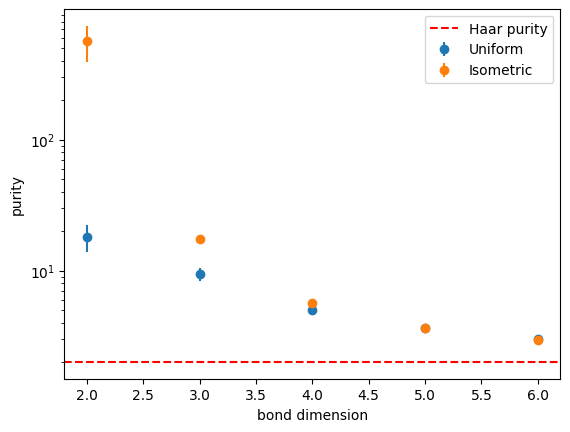

In [17]:
#plt.errorbar(chi_list, purities_g1, yerr=err_bars_g1, fmt='o', label='Gaussian $spread=1$')
plt.errorbar(chi_list, purities_u, yerr=err_bars_u, fmt='o', label='Uniform')
plt.errorbar(chi_list, purities, yerr=err_bars, fmt='o', label='Isometric')

hp = haar_purity(num_sites, k_copies, scaled=True, ti=False)
plt.axhline(hp, color="red", linestyle="--", label="Haar purity")

plt.yscale('log')
plt.xlabel("bond dimension")
plt.ylabel("purity")
plt.legend()


# Process Gaussian data

In [34]:
import os, sys, pickle
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

CURRENT_DIR = os.getcwd()
ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, ".."))
sys.path.append(ROOT_DIR)
from rmps_purity import samples_to_purity, samples_to_purity_with_error, haar_purity

def get_one_errs(chi):
    n_range = np.arange(10, 50, 2)
    included_n = []
    one_err = []
    one_err_uncert = []
    for n in n_range:
        file = os.path.join("data", f"gaussian_{n}_{chi}.pickle")
        if os.path.exists(file):
            with open(file, "rb") as f:
                data = pickle.load(f)

            samples = data["samples"]
            purity, purity_err = samples_to_purity_with_error(samples, k_copies)
            err = purity - haar_purity(n, k_copies, scaled=True, ti=False)

            if err > 0:
                sqrt_err = np.sqrt(err)
                sqrt_err_uncert = 0.5 * purity_err / sqrt_err  # propagate purity_err
                one_err.append(sqrt_err)
                one_err_uncert.append(sqrt_err_uncert)
                included_n.append(n)
            
            else: 
                print(f"Negative error for n={n}, chi={chi}: {err}")

    return included_n, one_err, one_err_uncert

def linear_regression_with_slope_error(x, y, y_err):
    x = np.array(x, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    y_err = np.array(y_err, dtype=np.float64)

    # Weights = 1/σ²
    w = 1 / y_err**2
    W = np.sum(w)
    x_bar = np.sum(w * x) / W
    y_bar = np.sum(w * y) / W

    # Slope
    S_xx = np.sum(w * (x - x_bar)**2)
    S_xy = np.sum(w * (x - x_bar) * (y - y_bar))
    slope = S_xy / S_xx

    # Intercept
    intercept = y_bar - slope * x_bar

    # Variance of slope
    slope_var = 1 / S_xx
    slope_std = np.sqrt(slope_var)

    return slope, slope_std, intercept

import scienceplots
def set_style(grid=True, axes_label_size=8, xtick_label_size=8, ytick_label_size=8, linewidth=1.5):
    plt.style.use(['science', 'grid', 'no-latex'])
    plt.rcParams['image.cmap'] = 'cividis'
    
    plt.rcParams['axes.labelsize'] = axes_label_size   
    plt.rcParams['xtick.labelsize'] = xtick_label_size  
    plt.rcParams['ytick.labelsize'] = ytick_label_size
    plt.rcParams['legend.fontsize'] = 8 
    plt.rcParams['lines.linewidth'] = linewidth
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.dpi'] = 300 
    
    plt.rcParams['axes.titlesize'] = 10
    
    plt.rcParams['axes.grid'] = grid  
    plt.rcParams['axes.spines.top'] = True 
    plt.rcParams['axes.spines.right'] = True

In [35]:
# test if data has been generated

chi_list = [14]
n_list = np.arange(4,50,2)
purities = []
for chi in chi_list: 
    for n in n_list:
        file = f"data/gaussian_{n}_{chi}.pickle"
        if os.path.exists(file):
            with open(file, "rb") as f:
                # try pickle.load 
                try:
                    data = pickle.load(f)
                except Exception as e:
                    print(f"Error loading file {file}: {e}")
                    continue

                samples = data["samples"]
                if len(samples) < 1e6: 
                    print(f"data for chi={chi} and n={n} exists but has {len(samples)} samples. Please generate more samples.")
        else: 
            print(f"bond dimension {chi} and n={n} not found in data directory. Please generate the data first.")
    print("")

data for chi=14 and n=4 exists but has 40000 samples. Please generate more samples.
data for chi=14 and n=6 exists but has 30000 samples. Please generate more samples.
data for chi=14 and n=8 exists but has 20000 samples. Please generate more samples.
data for chi=14 and n=10 exists but has 10000 samples. Please generate more samples.
data for chi=14 and n=12 exists but has 20000 samples. Please generate more samples.
data for chi=14 and n=14 exists but has 20000 samples. Please generate more samples.
bond dimension 14 and n=16 not found in data directory. Please generate the data first.
bond dimension 14 and n=18 not found in data directory. Please generate the data first.
data for chi=14 and n=20 exists but has 10000 samples. Please generate more samples.
bond dimension 14 and n=22 not found in data directory. Please generate the data first.
bond dimension 14 and n=24 not found in data directory. Please generate the data first.
bond dimension 14 and n=26 not found in data directory. 

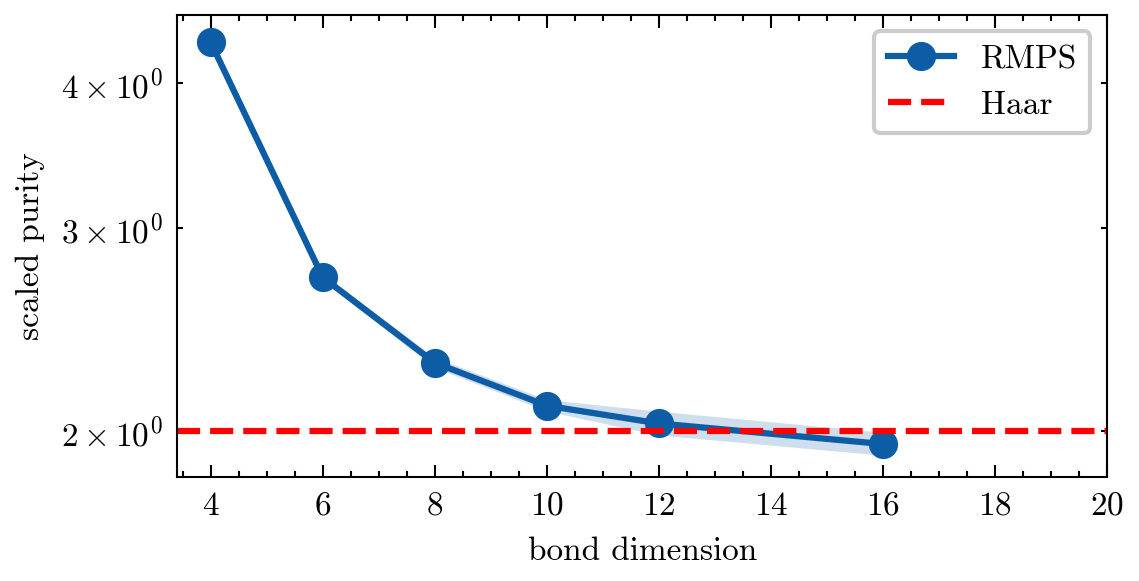

In [53]:
# test convergence
n = 16
chi_list = [4,6,8,10,12,16]
purities = []
err_bars = []
k_copies = 2 

for chi in chi_list:
    file = f"data/gaussian_{n}_{chi}.pickle"
    if os.path.exists(file):
        with open(file, "rb") as f:
            data = pickle.load(f)
        samples = data["samples"]
        purity, err = samples_to_purity_with_error(samples, k_copies)
        purities.append(purity)
        err_bars.append(err)
    else:
        print(f"file {file} not found.")

hp = haar_purity(n, k_copies, scaled=True, ti=False)

set_style(grid=False)
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(chi_list, purities, marker="o", label="RMPS")
ax.fill_between(chi_list, np.array(purities) - np.array(err_bars), np.array(purities) + np.array(err_bars), alpha=0.2)
ax.axhline(hp, color="red", linestyle="--", label="Haar")
ax.set_xlabel("bond dimension")
ax.set_ylabel("scaled purity")
ax.set_xticks(np.arange(4, 22, 2))
plt.legend()
plt.yscale('log')
#plt.savefig("figures/ng0.svg", bbox_inches='tight')

# Processing uniform data

In [54]:
import os, sys, pickle
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

CURRENT_DIR = os.getcwd()
ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, ".."))
sys.path.append(ROOT_DIR)
from rmps_purity import samples_to_purity, samples_to_purity_with_error, haar_purity

def get_one_errs(chi):
    n_range = np.arange(10, 50, 2)
    included_n = []
    one_err = []
    one_err_uncert = []
    for n in n_range:
        file = os.path.join("data", f"uniform_{n}_{chi}.pickle")
        if os.path.exists(file):
            with open(file, "rb") as f:
                data = pickle.load(f)

            samples = data["samples"]
            purity, purity_err = samples_to_purity_with_error(samples, k_copies)
            err = purity - haar_purity(n, k_copies, scaled=True, ti=False)

            if err > 0:
                sqrt_err = np.sqrt(err)
                sqrt_err_uncert = 0.5 * purity_err / sqrt_err  # propagate purity_err
                one_err.append(sqrt_err)
                one_err_uncert.append(sqrt_err_uncert)
                included_n.append(n)
            
            else: 
                print(f"Negative error for n={n}, chi={chi}: {err}")

    return included_n, one_err, one_err_uncert

def linear_regression_with_slope_error(x, y, y_err):
    x = np.array(x, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    y_err = np.array(y_err, dtype=np.float64)

    # Weights = 1/σ²
    w = 1 / y_err**2
    W = np.sum(w)
    x_bar = np.sum(w * x) / W
    y_bar = np.sum(w * y) / W

    # Slope
    S_xx = np.sum(w * (x - x_bar)**2)
    S_xy = np.sum(w * (x - x_bar) * (y - y_bar))
    slope = S_xy / S_xx

    # Intercept
    intercept = y_bar - slope * x_bar

    # Variance of slope
    slope_var = 1 / S_xx
    slope_std = np.sqrt(slope_var)

    return slope, slope_std, intercept

import scienceplots
def set_style(grid=True, axes_label_size=8, xtick_label_size=8, ytick_label_size=8, linewidth=1.5):
    plt.style.use(['science', 'grid', 'no-latex'])
    plt.rcParams['image.cmap'] = 'cividis'
    
    plt.rcParams['axes.labelsize'] = axes_label_size   
    plt.rcParams['xtick.labelsize'] = xtick_label_size  
    plt.rcParams['ytick.labelsize'] = ytick_label_size
    plt.rcParams['legend.fontsize'] = 8 
    plt.rcParams['lines.linewidth'] = linewidth
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.dpi'] = 300 
    
    plt.rcParams['axes.titlesize'] = 10
    
    plt.rcParams['axes.grid'] = grid  
    plt.rcParams['axes.spines.top'] = True 
    plt.rcParams['axes.spines.right'] = True

In [55]:
# test if data has been generated

chi_list = [14]
n_list = np.arange(4,50,2)
purities = []
for chi in chi_list: 
    for n in n_list:
        file = f"data/uniform_{n}_{chi}.pickle"
        if os.path.exists(file):
            with open(file, "rb") as f:
                # try pickle.load 
                try:
                    data = pickle.load(f)
                except Exception as e:
                    print(f"Error loading file {file}: {e}")
                    continue

                samples = data["samples"]
                if len(samples) < 1e6: 
                    print(f"data for chi={chi} and n={n} exists but has {len(samples)} samples. Please generate more samples.")
        else: 
            print(f"bond dimension {chi} and n={n} not found in data directory. Please generate the data first.")
    print("")

data for chi=14 and n=4 exists but has 70000 samples. Please generate more samples.
data for chi=14 and n=6 exists but has 40000 samples. Please generate more samples.
data for chi=14 and n=8 exists but has 10000 samples. Please generate more samples.
data for chi=14 and n=10 exists but has 100000 samples. Please generate more samples.
bond dimension 14 and n=12 not found in data directory. Please generate the data first.
data for chi=14 and n=14 exists but has 60000 samples. Please generate more samples.
bond dimension 14 and n=16 not found in data directory. Please generate the data first.
bond dimension 14 and n=18 not found in data directory. Please generate the data first.
bond dimension 14 and n=20 not found in data directory. Please generate the data first.
bond dimension 14 and n=22 not found in data directory. Please generate the data first.
bond dimension 14 and n=24 not found in data directory. Please generate the data first.
bond dimension 14 and n=26 not found in data dire

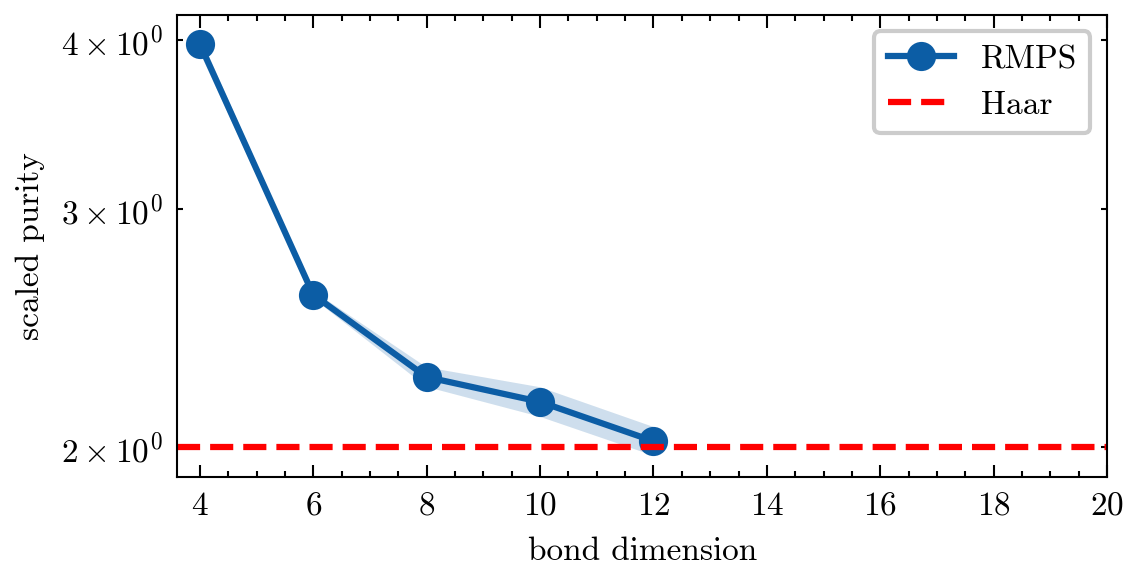

In [64]:
# test convergence
n = 16
chi_list = [4,6,8,10,12]
purities = []
err_bars = []
k_copies = 2 

for chi in chi_list:
    file = f"data/uniform_{n}_{chi}.pickle"
    if os.path.exists(file):
        with open(file, "rb") as f:
            data = pickle.load(f)
        samples = data["samples"]
        purity, err = samples_to_purity_with_error(samples, k_copies)
        purities.append(purity)
        err_bars.append(err)
    else:
        print(f"file {file} not found.")

hp = haar_purity(n, k_copies, scaled=True, ti=False)

set_style(grid=False)
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(chi_list, purities, marker="o", label="RMPS")
ax.fill_between(chi_list, np.array(purities) - np.array(err_bars), np.array(purities) + np.array(err_bars), alpha=0.2)
ax.axhline(hp, color="red", linestyle="--", label="Haar")
ax.set_xlabel("bond dimension")
ax.set_ylabel("scaled purity")
ax.set_xticks(np.arange(4, 22, 2))
plt.legend()
plt.yscale('log')
#plt.savefig("figures/ng0.svg", bbox_inches='tight')

# Processing open data

In [135]:
import os, sys, pickle
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

CURRENT_DIR = os.getcwd()
ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, ".."))
sys.path.append(ROOT_DIR)
from rmps_purity import samples_to_purity, samples_to_purity_with_error, haar_purity

def get_one_errs(chi):
    n_range = np.arange(10, 50, 2)
    included_n = []
    one_err = []
    one_err_uncert = []
    for n in n_range:
        file = os.path.join("data", f"open_{n}_{chi}.pickle")
        if os.path.exists(file):
            with open(file, "rb") as f:
                data = pickle.load(f)

            samples = data["samples"]
            purity, purity_err = samples_to_purity_with_error(samples, k_copies)
            err = purity - haar_purity(n, k_copies, scaled=True, ti=False)

            if err > 0:
                sqrt_err = np.sqrt(err)
                sqrt_err_uncert = 0.5 * purity_err / sqrt_err  # propagate purity_err
                one_err.append(sqrt_err)
                one_err_uncert.append(sqrt_err_uncert)
                included_n.append(n)
            
            else: 
                print(f"Negative error for n={n}, chi={chi}: {err}")

    return included_n, one_err, one_err_uncert

def linear_regression_with_slope_error(x, y, y_err):
    x = np.array(x, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    y_err = np.array(y_err, dtype=np.float64)

    # Weights = 1/σ²
    w = 1 / y_err**2
    W = np.sum(w)
    x_bar = np.sum(w * x) / W
    y_bar = np.sum(w * y) / W

    # Slope
    S_xx = np.sum(w * (x - x_bar)**2)
    S_xy = np.sum(w * (x - x_bar) * (y - y_bar))
    slope = S_xy / S_xx

    # Intercept
    intercept = y_bar - slope * x_bar

    # Variance of slope
    slope_var = 1 / S_xx
    slope_std = np.sqrt(slope_var)

    return slope, slope_std, intercept

import scienceplots
def set_style(grid=True, axes_label_size=8, xtick_label_size=8, ytick_label_size=8, linewidth=1.5):
    plt.style.use(['science', 'grid', 'no-latex'])
    plt.rcParams['image.cmap'] = 'cividis'
    
    plt.rcParams['axes.labelsize'] = axes_label_size   
    plt.rcParams['xtick.labelsize'] = xtick_label_size  
    plt.rcParams['ytick.labelsize'] = ytick_label_size
    plt.rcParams['legend.fontsize'] = 8 
    plt.rcParams['lines.linewidth'] = linewidth
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.dpi'] = 300 
    
    plt.rcParams['axes.titlesize'] = 10
    
    plt.rcParams['axes.grid'] = grid  
    plt.rcParams['axes.spines.top'] = True 
    plt.rcParams['axes.spines.right'] = True

In [149]:
# test if data has been generated

chi_list = [24]
n_list = np.arange(10,50,2)
purities = []

incompletes = []
undones = []
for chi in chi_list: 
    for n in n_list:
        file = f"data/open_{n}_{chi}.pickle"
        if os.path.exists(file):
            with open(file, "rb") as f:
                data = pickle.load(f)
            samples = data["samples"]
            if len(samples) < 1e6: 
                #pass
                incompletes.append(n)
                print(f"data for chi={chi} and n={n} exists but has {len(samples)} samples. Please generate more samples.")
        else: 
            undones.append(n)
            print(f"bond dimension {chi} and n={n} not found in data directory. Please generate the data first.")
            pass
    print("")
print(incompletes)
print(undones)

data for chi=24 and n=30 exists but has 430000 samples. Please generate more samples.
data for chi=24 and n=34 exists but has 70000 samples. Please generate more samples.
data for chi=24 and n=36 exists but has 820000 samples. Please generate more samples.
bond dimension 24 and n=38 not found in data directory. Please generate the data first.
data for chi=24 and n=40 exists but has 530000 samples. Please generate more samples.
bond dimension 24 and n=42 not found in data directory. Please generate the data first.
data for chi=24 and n=44 exists but has 210000 samples. Please generate more samples.
bond dimension 24 and n=46 not found in data directory. Please generate the data first.
bond dimension 24 and n=48 not found in data directory. Please generate the data first.

[30, 34, 36, 40, 44]
[38, 42, 46, 48]


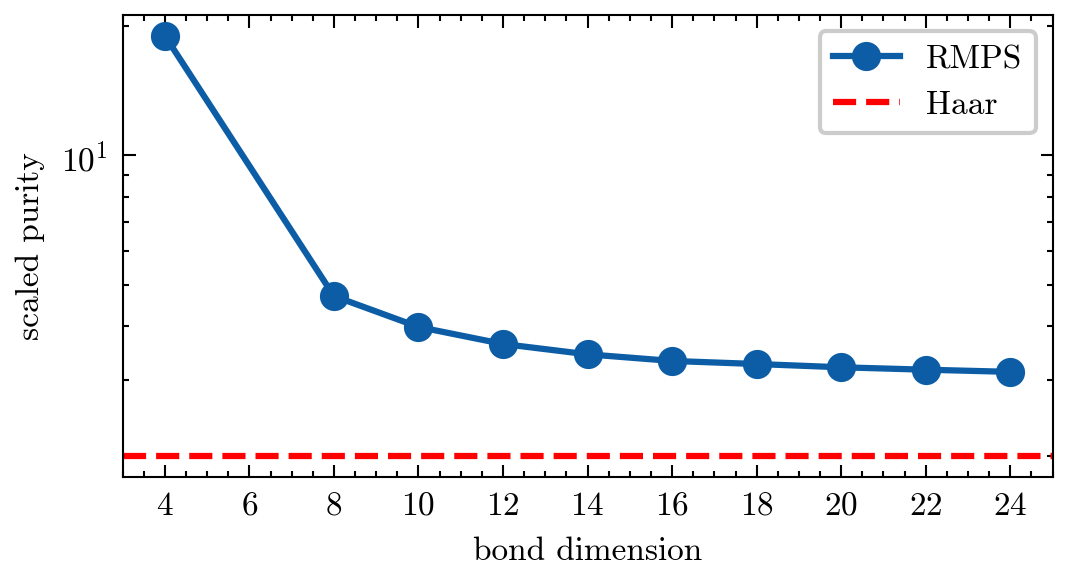

In [163]:
# test convergence
n = 30
chi_list = [4,8,10,12,14,16,18,20,22,24]
purities = []
err_bars = []
k_copies = 2 

for chi in chi_list:
    file = f"data/open_{n}_{chi}.pickle"
    if os.path.exists(file):
        with open(file, "rb") as f:
            data = pickle.load(f)
        samples = data["samples"]
        purity, err = samples_to_purity_with_error(samples, k_copies)
        purities.append(purity)
        err_bars.append(err)
    else:
        print(f"file {file} not found.")

hp = haar_purity(n, k_copies, scaled=True, ti=False)

set_style(grid=False)
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(chi_list, purities, marker="o", label="RMPS")
ax.axhline(hp, color="red", linestyle="--", label="Haar")
ax.set_xlabel("bond dimension")
ax.set_ylabel("scaled purity")
ax.set_xticks(np.arange(4, 26, 2))
plt.legend()
plt.yscale('log')
plt.savefig("no0.svg", bbox_inches='tight')

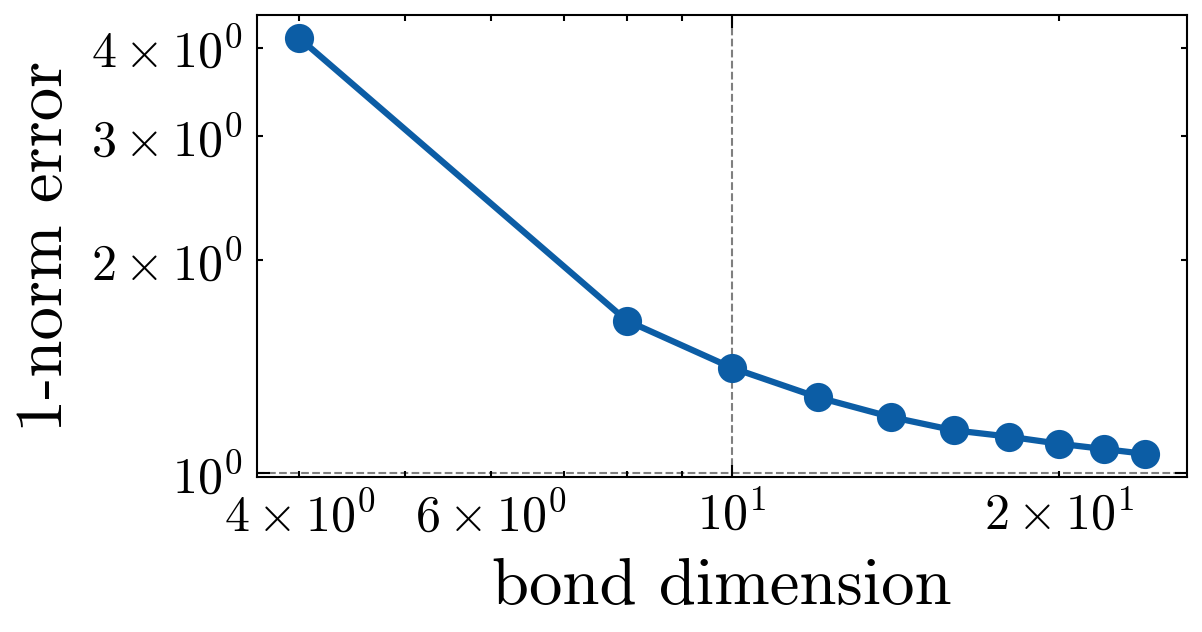

In [165]:
set_style(grid=True, axes_label_size=16, xtick_label_size=12, ytick_label_size=12)
fig, ax = plt.subplots(figsize=(4, 2))

one_err_sq = np.array(purities) - hp
one_err = np.sqrt(one_err_sq)
err_one_err = err_bars / (2 * one_err)

ax.plot(chi_list, one_err, marker="o")
ax.fill_between(chi_list, one_err - err_one_err, one_err + err_one_err, alpha=0.2)

# have y axis ticks at [0.01, 0.1, 1, 10, 100]


ax.set_xlabel("bond dimension")
ax.set_ylabel("1-norm error")
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_yticks([1,100,10000])
plt.savefig("no1.svg", bbox_inches='tight')

In [169]:
n_arr = []
one_err_arr = []

slope_list = []
intercept_list = []
slope_err_list = []
chi_list = [8,10,12,14,18,20,24]
k_copies = 2

for chi in chi_list:
    included_n, one_err, one_err_uncert = get_one_errs(chi)
    slope, slope_err, intercept = linear_regression_with_slope_error(included_n, one_err, one_err_uncert)
    slope_list.append(slope)
    slope_err_list.append(slope_err)
    n_arr.append(included_n)
    one_err_arr.append(one_err)
    intercept_list.append(intercept)

    print(f"Bond dimension: {chi}, Slope: {slope:.5f} ± {slope_err:.5f}")

drop = 0
result = linregress(np.log(chi_list[drop:]), np.log(slope_list[drop:]))
print(f"Slope: {result.slope}, Intercept: {result.intercept}, R-squared: {result.rvalue**2}, P-value: {result.pvalue}")
fitted_line = np.exp(result.intercept) * np.array(chi_list[drop:])**result.slope

Bond dimension: 8, Slope: 0.02208 ± 0.00014
Bond dimension: 10, Slope: 0.01829 ± 0.00016
Bond dimension: 12, Slope: 0.01273 ± 0.00013
Bond dimension: 14, Slope: 0.00949 ± 0.00014
Bond dimension: 18, Slope: 0.00593 ± 0.00014
Bond dimension: 20, Slope: 0.00468 ± 0.00014
Bond dimension: 24, Slope: 0.00334 ± 0.00015
Slope: -1.7917259128650176, Intercept: 0.03467237756225661, R-squared: 0.9900501997206579, P-value: 3.3648388953758096e-06


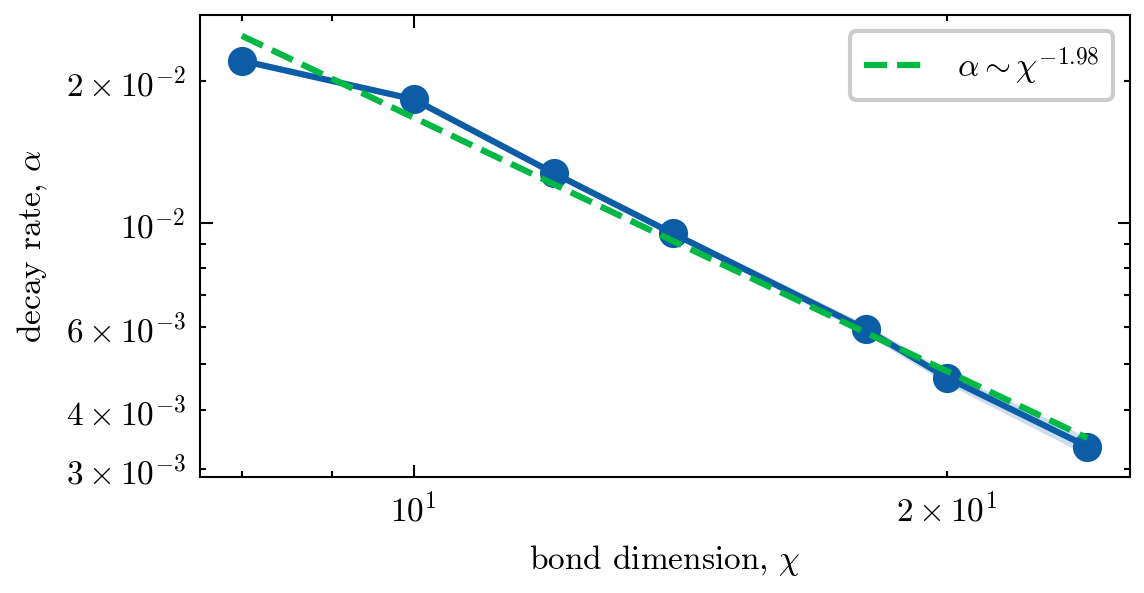

In [170]:
set_style(grid=False)
fig, ax = plt.subplots(figsize=(4, 2))

ax.plot(chi_list, slope_list, marker="o")
ax.fill_between(chi_list, np.array(slope_list) - np.array(slope_err_list), np.array(slope_list) + np.array(slope_err_list), alpha=0.2)
ax.plot(chi_list[drop:], fitted_line, linestyle="--", label=r"$\alpha\sim \chi^{-1.98}$")

ax.set_xlabel(r"bond dimension, $\chi$")
ax.set_ylabel(r"decay rate, $\alpha$")
ax.set_yscale('log')
ax.set_xscale('log')

plt.legend()
plt.savefig("no2.svg", bbox_inches='tight')

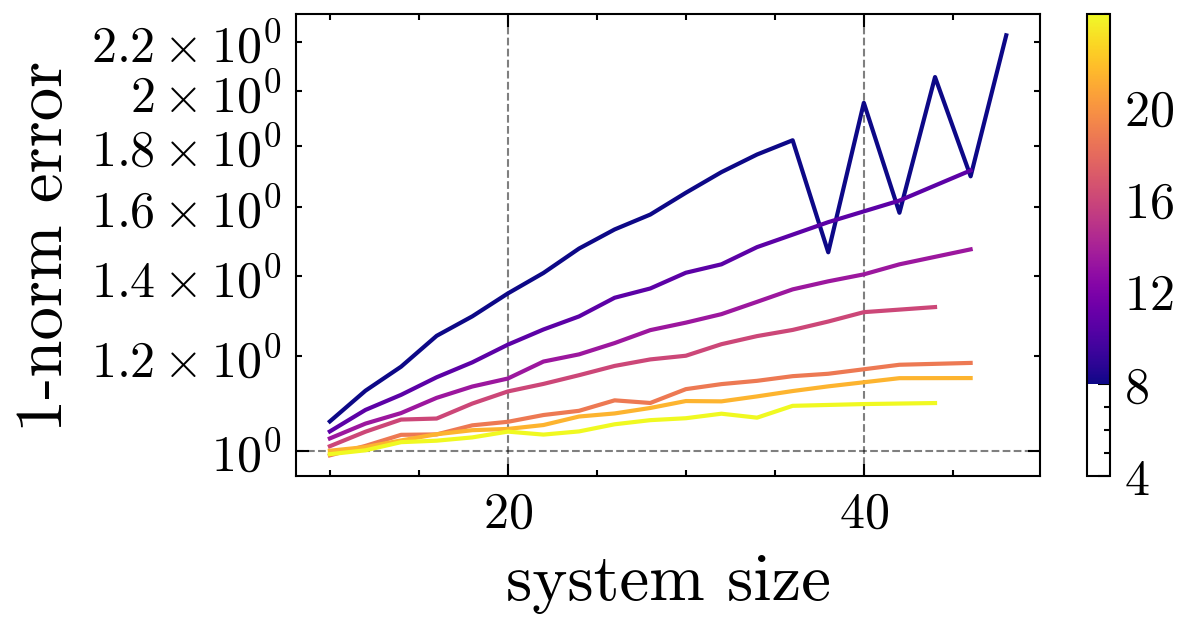

In [171]:
set_style(grid=True, axes_label_size=16, xtick_label_size=12, ytick_label_size=12, linewidth=1)

fig, ax = plt.subplots(figsize=(4, 2))
colors = plt.cm.plasma(np.linspace(0, 1, len(chi_list)))


for i in range(len(chi_list)):
    ax.plot(n_arr[i], one_err_arr[i], color=colors[i])

import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=chi_list[0], vmax=chi_list[-1])
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_ticks(np.arange(4, 22, 4))

ax.set_xlabel("system size")
ax.set_ylabel("1-norm error")
plt.yscale("log")
plt.savefig("no3.svg", bbox_inches='tight')